In [56]:
from copy import copy
import os
from collections import defaultdict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch, ArrowStyle
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerBase
from brokenaxes import brokenaxes
import seaborn as sns
import pandas as pd
import pickle

from utils.constants import xai_names, tasks, tasks_new


xai_names = [explainer for explainer in xai_names if explainer != 'IntegratedGradients']

# tasks = sorted(tasks + tasks_new)
# tasks = [task for task in tasks if task != 'GunPointMaleVersusFemale']
tasks =['Chinatown', 'Coffee', 'Computers', 'DistalPhalanxOutlineCorrect', 'ECG200', 'ECGFiveDays', 'GunPoint', 'Lightning2', 'PowerCons', 'Strawberry', 'TwoLeadECG', 'Earthquakes', 'FordA']

task_name_map = {t: t for t in tasks}
task_name_map['DistalPhalanxOutlineCorrect'] = 'DPOC'
# task_name_map['GunPointMaleVersusFemale'] = 'GunPointGender'

print(xai_names)
print(tasks)
print(task_name_map)

['DeepLift', 'InputXGradient', 'Saliency', 'Lime', 'Occlusion', 'KernelShap', 'GuidedBackprop']
['Chinatown', 'Coffee', 'Computers', 'DistalPhalanxOutlineCorrect', 'ECG200', 'ECGFiveDays', 'GunPoint', 'Lightning2', 'PowerCons', 'Strawberry', 'TwoLeadECG', 'Earthquakes', 'FordA']
{'Chinatown': 'Chinatown', 'Coffee': 'Coffee', 'Computers': 'Computers', 'DistalPhalanxOutlineCorrect': 'DPOC', 'ECG200': 'ECG200', 'ECGFiveDays': 'ECGFiveDays', 'GunPoint': 'GunPoint', 'Lightning2': 'Lightning2', 'PowerCons': 'PowerCons', 'Strawberry': 'Strawberry', 'TwoLeadECG': 'TwoLeadECG', 'Earthquakes': 'Earthquakes', 'FordA': 'FordA'}


In [96]:
df_imp = pd.read_csv(f'output/blurring_test_all.csv')
# df_imp = pd.read_csv(f'output/blurring_test_mean_repl.csv')
df_st = pd.read_csv(f'output/blurring_test_ST.csv')

# mean_acc_st = df_st.groupby(['task_name', 'xai_name', 'method'])['acc_score'].mean()
# df_st = df_st.merge(mean_acc_st, on=['task_name', 'xai_name', 'method'])
# df_st.drop(columns=['acc_score_x'], inplace=True)
# df_st.rename(columns={'acc_score_y': 'acc_score'}, inplace=True)

df = pd.concat([df_imp, df_st])
df.replace('DistalPhalanxOutlineCorrect', 'DPOC', inplace=True)
df.replace('GunPointMaleVersusFemale', 'GunPointGender', inplace=True)
df.head()

,model_name,task_name,xai_name,method,acc_score
0,FCN,GunPoint,NaN,ori,1.000000
1,FCN,GunPoint,GuidedBackprop,repl_implet,0.886667
2,FCN,GunPoint,GuidedBackprop,repl_random_loc,0.946667
3,FCN,GunPoint,GuidedBackprop,repl_implet,0.860000
4,FCN,GunPoint,GuidedBackprop,repl_random_loc,0.966667


In [97]:
df['xai_name'].unique()

array([nan, 'GuidedBackprop', 'InputXGradient', 'KernelShap', 'Lime',
       'Occlusion', 'Saliency', 'ShapeletTransform'], dtype=object)

In [98]:
baseline = df[df['xai_name'].isnull()]
df = df[~df['xai_name'].isnull()]
baseline.head()

,model_name,task_name,xai_name,method,acc_score
0,FCN,GunPoint,NaN,ori,1.000000
121,FCN,ECG200,NaN,ori,0.860000
242,FCN,DPOC,NaN,ori,0.768116
363,FCN,PowerCons,NaN,ori,0.933333
484,FCN,Earthquakes,NaN,ori,0.748201


In [99]:
df = df.merge(baseline, on=['model_name', 'task_name'], how='left')
df['acc_drop'] = df['acc_score_y'] - df['acc_score_x']
df.drop(columns=['xai_name_y', 'method_y', 'acc_score_x', 'acc_score_y'], inplace=True)
df.head()

,model_name,task_name,xai_name_x,method_x,acc_drop
0,FCN,GunPoint,GuidedBackprop,repl_implet,0.113333
1,FCN,GunPoint,GuidedBackprop,repl_implet,0.113333
2,FCN,GunPoint,GuidedBackprop,repl_random_loc,0.053333
3,FCN,GunPoint,GuidedBackprop,repl_random_loc,0.053333
4,FCN,GunPoint,GuidedBackprop,repl_implet,0.140000


In [100]:
df = df.groupby(['model_name', 'task_name', 'xai_name_x', 'method_x']).mean().reset_index()

<Figure size 640x480 with 0 Axes>

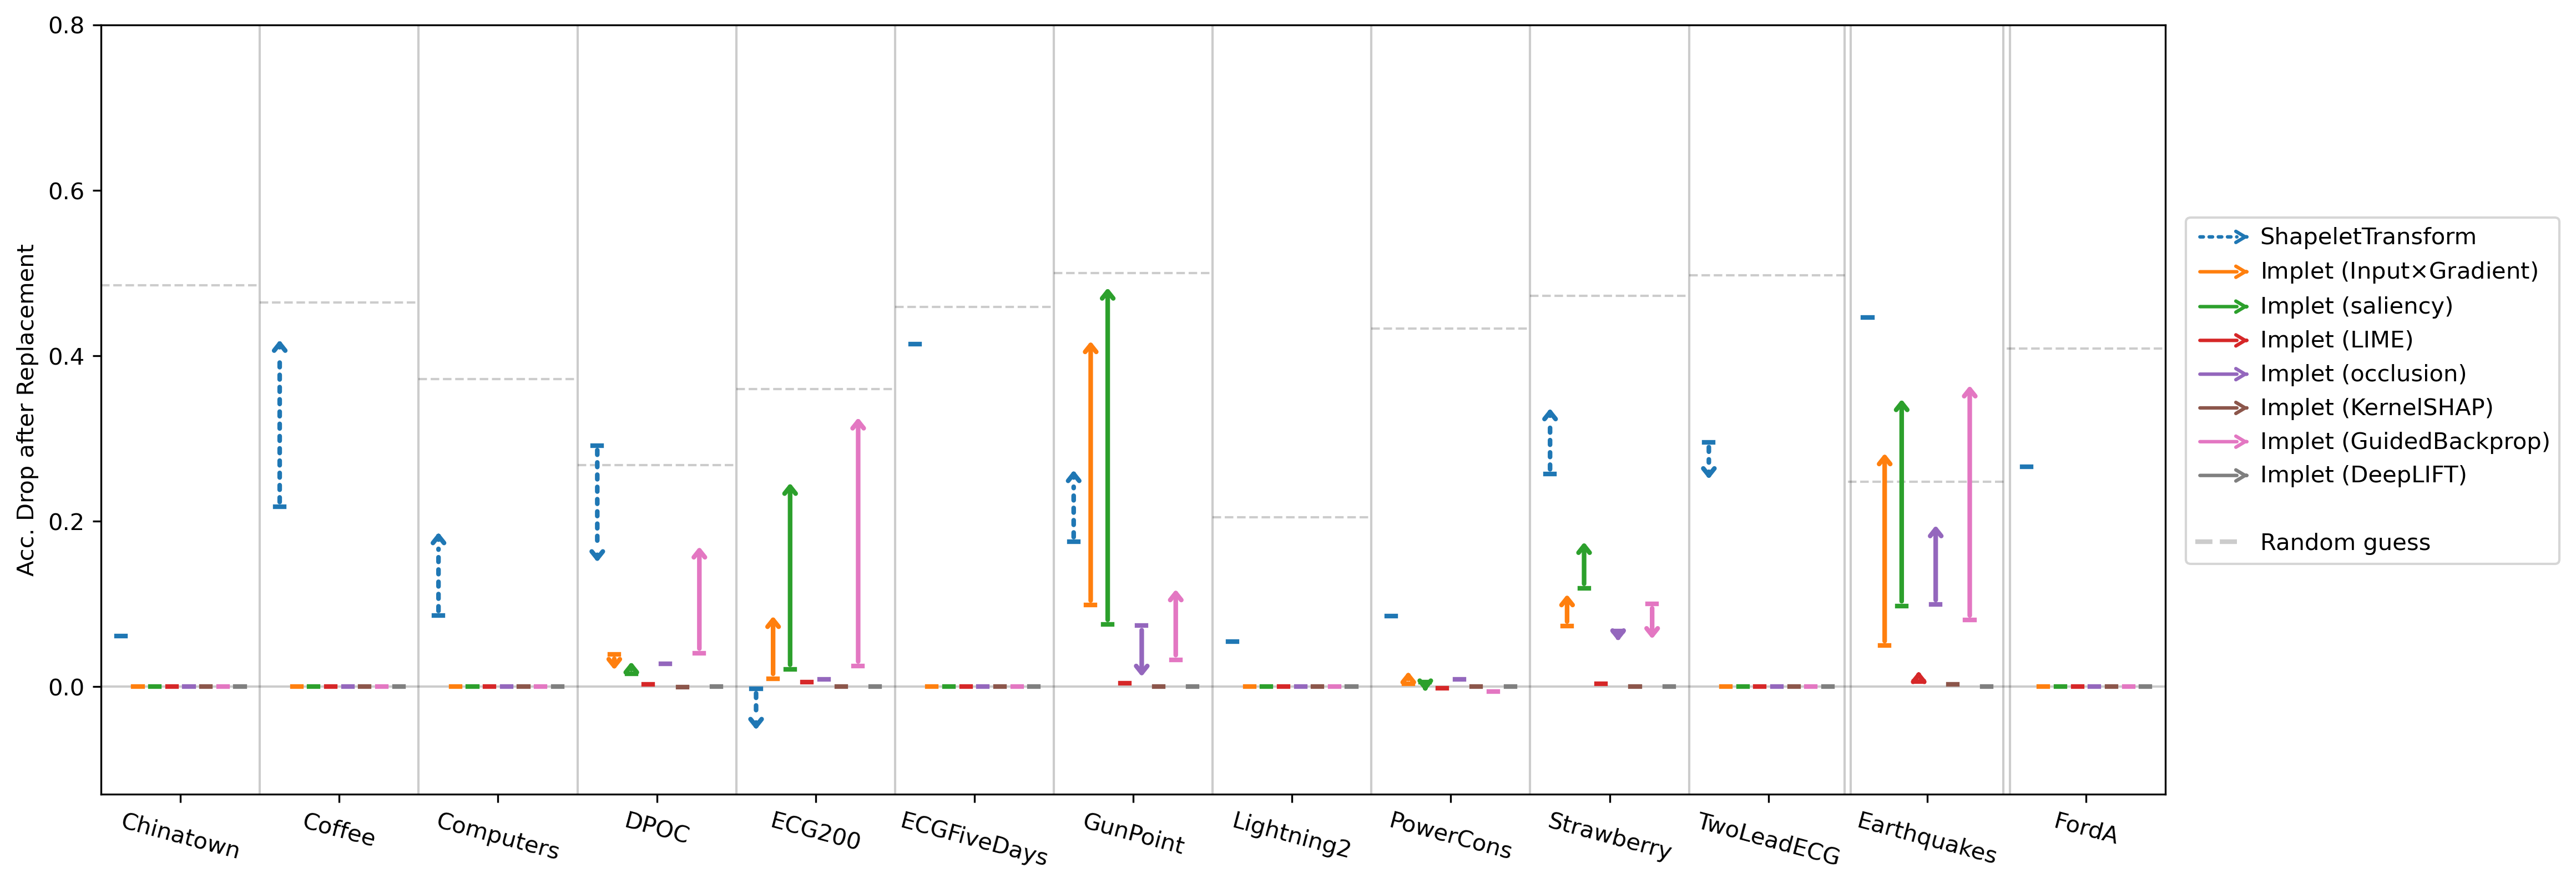

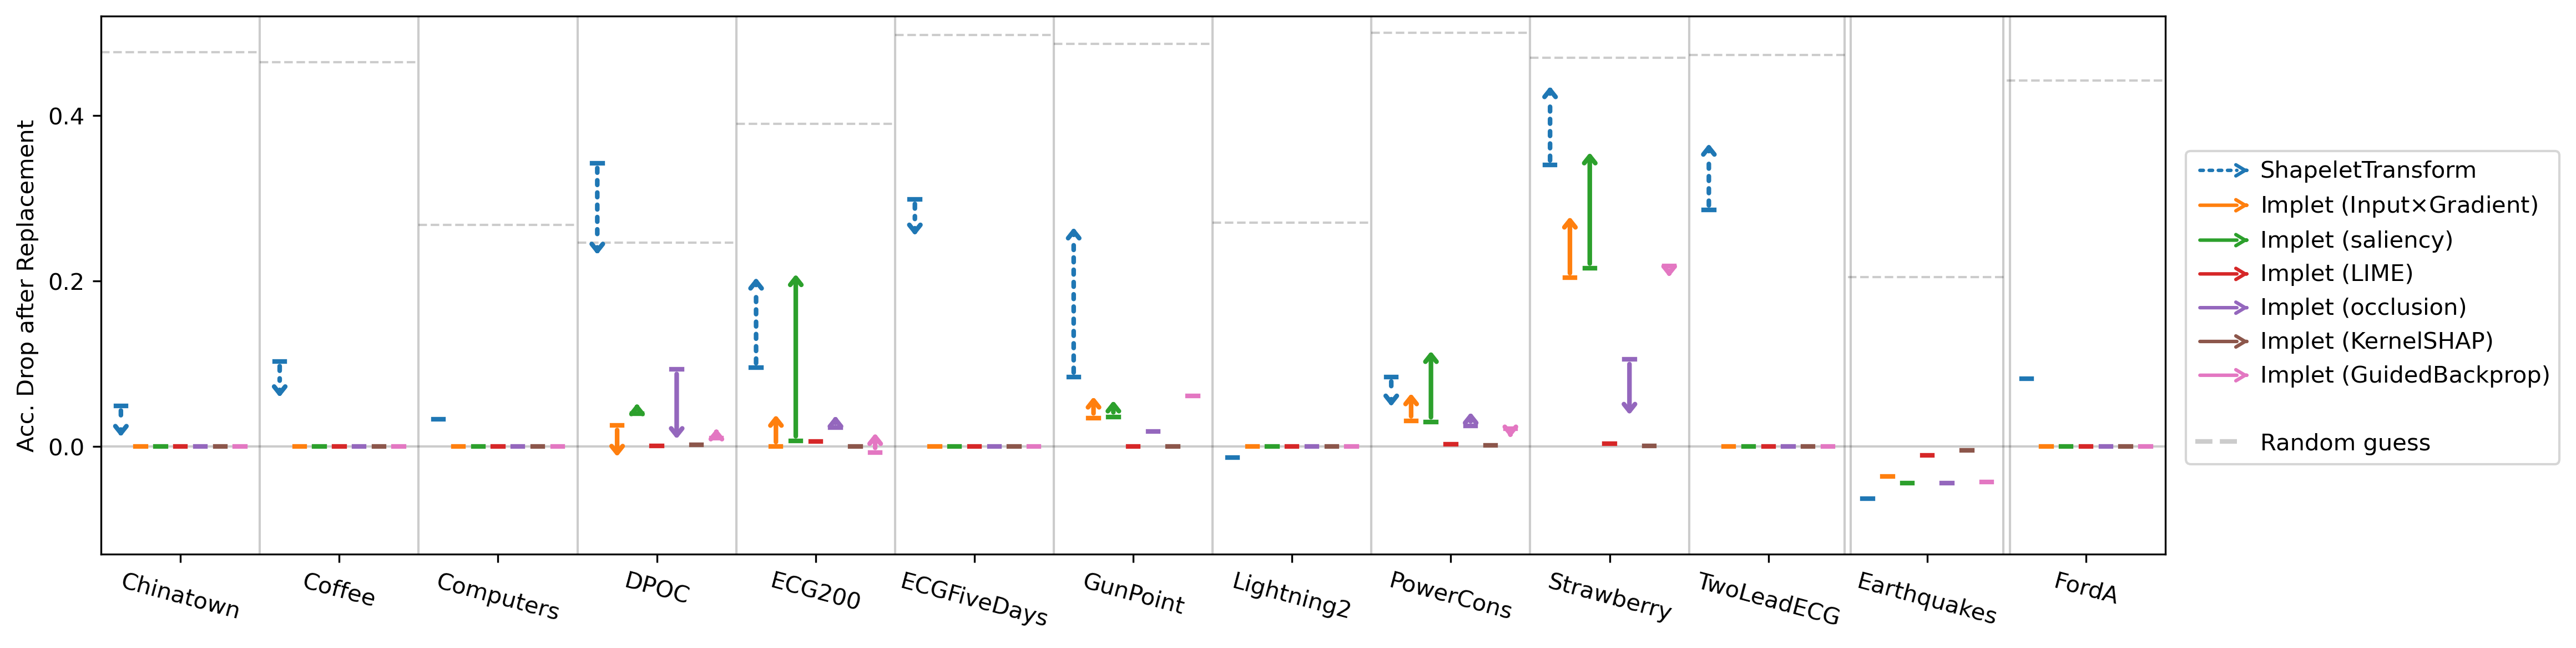

In [101]:
# sns.pointplot(df[(df['model_name'] == 'FCN') & (df['method_x'] == 'repl_implet')], x='task_name', y='acc_drop', hue='xai_name_x', dodge=0.6, ls='', marker='o', markersize=5)
# sns.pointplot(df[(df['model_name'] == 'FCN') & (df['method_x'] == 'repl_random_loc')], x='task_name', y='acc_drop', hue='xai_name_x', dodge=0.6, ls='', marker='x', markersize=5)

dodge = 0.75
arrow_thresh = 0.015

arrowstyle = ArrowStyle.CurveB(head_length=0.15, head_width=0.12)
arrowstyle_legend = ArrowStyle.CurveB(head_length=0.2, head_width=0.12)

legend_map = {explainer: explainer for explainer in ['ShapeletTransform'] + xai_names}
del legend_map['DeepLift']
legend_map['KernelShap'] = 'KernelSHAP'
legend_map['Saliency'] = 'saliency'
legend_map['Occlusion'] = 'occlusion'
legend_map['Lime'] = 'LIME'
legend_map['InputXGradient'] = 'Input$\\times$Gradient'
legend_map['DeepLift'] = 'DeepLIFT'

plt.clf()

for model_name in ['FCN', 'InceptionTime']:
    ylim = (-0.13, 0.8) if model_name == 'FCN' else (-0.13, 0.52)
    fig, ax = plt.subplots(dpi=300, figsize=(16, 6 * (ylim[1] - ylim[0]) / 0.93))
    # fig = plt.figure(dpi=300, figsize=(24, 6))
    # if model_name == 'FCN':
    #     ax = brokenaxes(xlims=((-0.5, 13.5),), ylims=((-0.12, 0.47), (0.55, 0.8)), hspace=.05, d=0.005)
    # else:
    #     ax = brokenaxes(xlims=((-0.5, 13.5),), ylims=((-0.12, 0.57), (0.65, 0.8)), hspace=.05, d=0.005)

    # plot random guess line
    for j, task in enumerate(task_name_map.values()):
        acc = baseline[(baseline['model_name'] == model_name) & (baseline['task_name'] == task)]['acc_score'].mean()
        ax.plot([j - 0.5, j + 0.5], [acc - 0.5, acc - 0.5], lw=1, color='black', alpha=0.2, zorder=-1, ls='--')

    explainers = ['ShapeletTransform'] + xai_names[1:]
    if model_name != 'InceptionTime':
        explainers.append(xai_names[0])
    
    dodge_amounts = np.linspace(-dodge / 2, dodge / 2, len(explainers))
    arrow_tail_width = dodge / len(explainers) / 2 * 0.6
    
    for i, explainer in enumerate(explainers):
        for j, task in enumerate(task_name_map.values()):
            data = df[
                (df['model_name'] == model_name)
                & (df['xai_name_x'] == explainer)
                & (df['task_name'] == task)
            ]
            x = j + dodge_amounts[i]

            if data[data['method_x'] == 'repl_implet'].empty:
                ax.plot([x - arrow_tail_width, x + arrow_tail_width], [0, 0], lw=2, color=plt.get_cmap('tab10')(i))
            else:
                y_subseq = data[data['method_x'] == 'repl_implet']['acc_drop'].values[0]
                y_rand = data[data['method_x'] == 'repl_random_loc']['acc_drop'].values[0]

                if np.abs(y_subseq - y_rand) < arrow_thresh:
                    y_mean = (y_subseq + y_rand) / 2
                    ax.plot([x - arrow_tail_width, x + arrow_tail_width], [y_mean, y_mean], lw=2, color=plt.get_cmap('tab10')(i))

                else:
                    if explainer == 'ShapeletTransform':
                        arrow = FancyArrowPatch((x, y_rand), (x, y_subseq), arrowstyle='-', ls=':',
                                                    mutation_scale=20, color=plt.get_cmap('tab10')(i), lw=2)
                        ax.add_patch(arrow)

                        if y_subseq > y_rand:
                            y_start, y_end = y_subseq, y_subseq + 0.02
                        else:
                            y_start, y_end = y_subseq, y_subseq - 0.02
                        
                        arrow_head = FancyArrowPatch((x, y_start), (x, y_end), arrowstyle=arrowstyle, zorder=2,
                                                     mutation_scale=20, color=plt.get_cmap('tab10')(i), lw=2)
                        ax.add_patch(arrow_head)
                    else:
                        arrow = FancyArrowPatch((x, y_rand), (x, y_subseq), arrowstyle=arrowstyle,
                                                mutation_scale=20, color=plt.get_cmap('tab10')(i), lw=2)
                        ax.add_patch(arrow)
                    ax.plot([x - arrow_tail_width, x + arrow_tail_width], [y_rand, y_rand], lw=2, color=plt.get_cmap('tab10')(i))
                

    ax.axhline(0, lw=1, color='black', alpha=0.2, zorder=-1)
    for i in range(len(tasks) - 1):
        if i == 10 or i == 11:
            ax.axvline(i + 0.48, lw=1, color='black', alpha=0.2, zorder=-1)
            ax.axvline(i + 0.52, lw=1, color='black', alpha=0.2, zorder=-1)
        else:
            ax.axvline(i + 0.5, lw=1, color='black', alpha=0.2, zorder=-1)
    ax.set_xticks(np.arange(len(tasks)), task_name_map.values(), rotation=-15)
    ax.set_xlim(-0.5, 12.5)
    ax.set_ylim(*ylim)

    ax.set_ylabel('Acc. Drop after Replacement')
    ytick_start = ylim[0] - ((ylim[0] + 1e-10) % 0.2) + 0.2
    ax.set_yticks(np.arange(ytick_start, ylim[1] + 1e-4, 0.2))
    
    # # custom legends
    class ArrowHandler(HandlerBase):
        def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
            if orig_handle.get_linestyle() == 'solid':
                arrow = FancyArrowPatch((0, 3), (25, 3), ls=orig_handle.get_linestyle(), lw=1.5,
                                        arrowstyle=arrowstyle_legend, color=orig_handle.get_edgecolor(), 
                                        mutation_scale=20)
                return [arrow]
            else:
                arrow = FancyArrowPatch((0, 3), (20, 3), arrowstyle='-', ls=orig_handle.get_linestyle(),  lw=1.5,
                                        color=orig_handle.get_edgecolor(), mutation_scale=20)
                arrow_head = FancyArrowPatch((22, 3), (23, 3), arrowstyle=arrowstyle_legend, ls='-', lw=1.5,
                                             color=orig_handle.get_edgecolor(), mutation_scale=20)
                return [arrow, arrow_head]
            
    legend_elements = [
        FancyArrowPatch((0, 0), (0, 0), arrowstyle='->',
                        ls=':' if explainer == 'ShapeletTransform' else '-',
                        color=plt.get_cmap('tab10')(i), 
                        label=f'Implet ({legend_map[explainer]})' if explainer != 'ShapeletTransform' else explainer)
        for i, explainer in enumerate(explainers)
    ]

    legend_elements.extend([
        Line2D([0], [0], lw=2, color='white', alpha=0, label=''),
        Line2D([0], [0], lw=2, color='black', alpha=0.2, ls='--', label='Random guess')
    ])

    ax.legend(handles=legend_elements, handler_map={FancyArrowPatch: ArrowHandler()},
               bbox_to_anchor=(1.01, 0.75), loc='upper left', borderaxespad=0.)
    plt.show()
    

<Figure size 640x480 with 0 Axes>

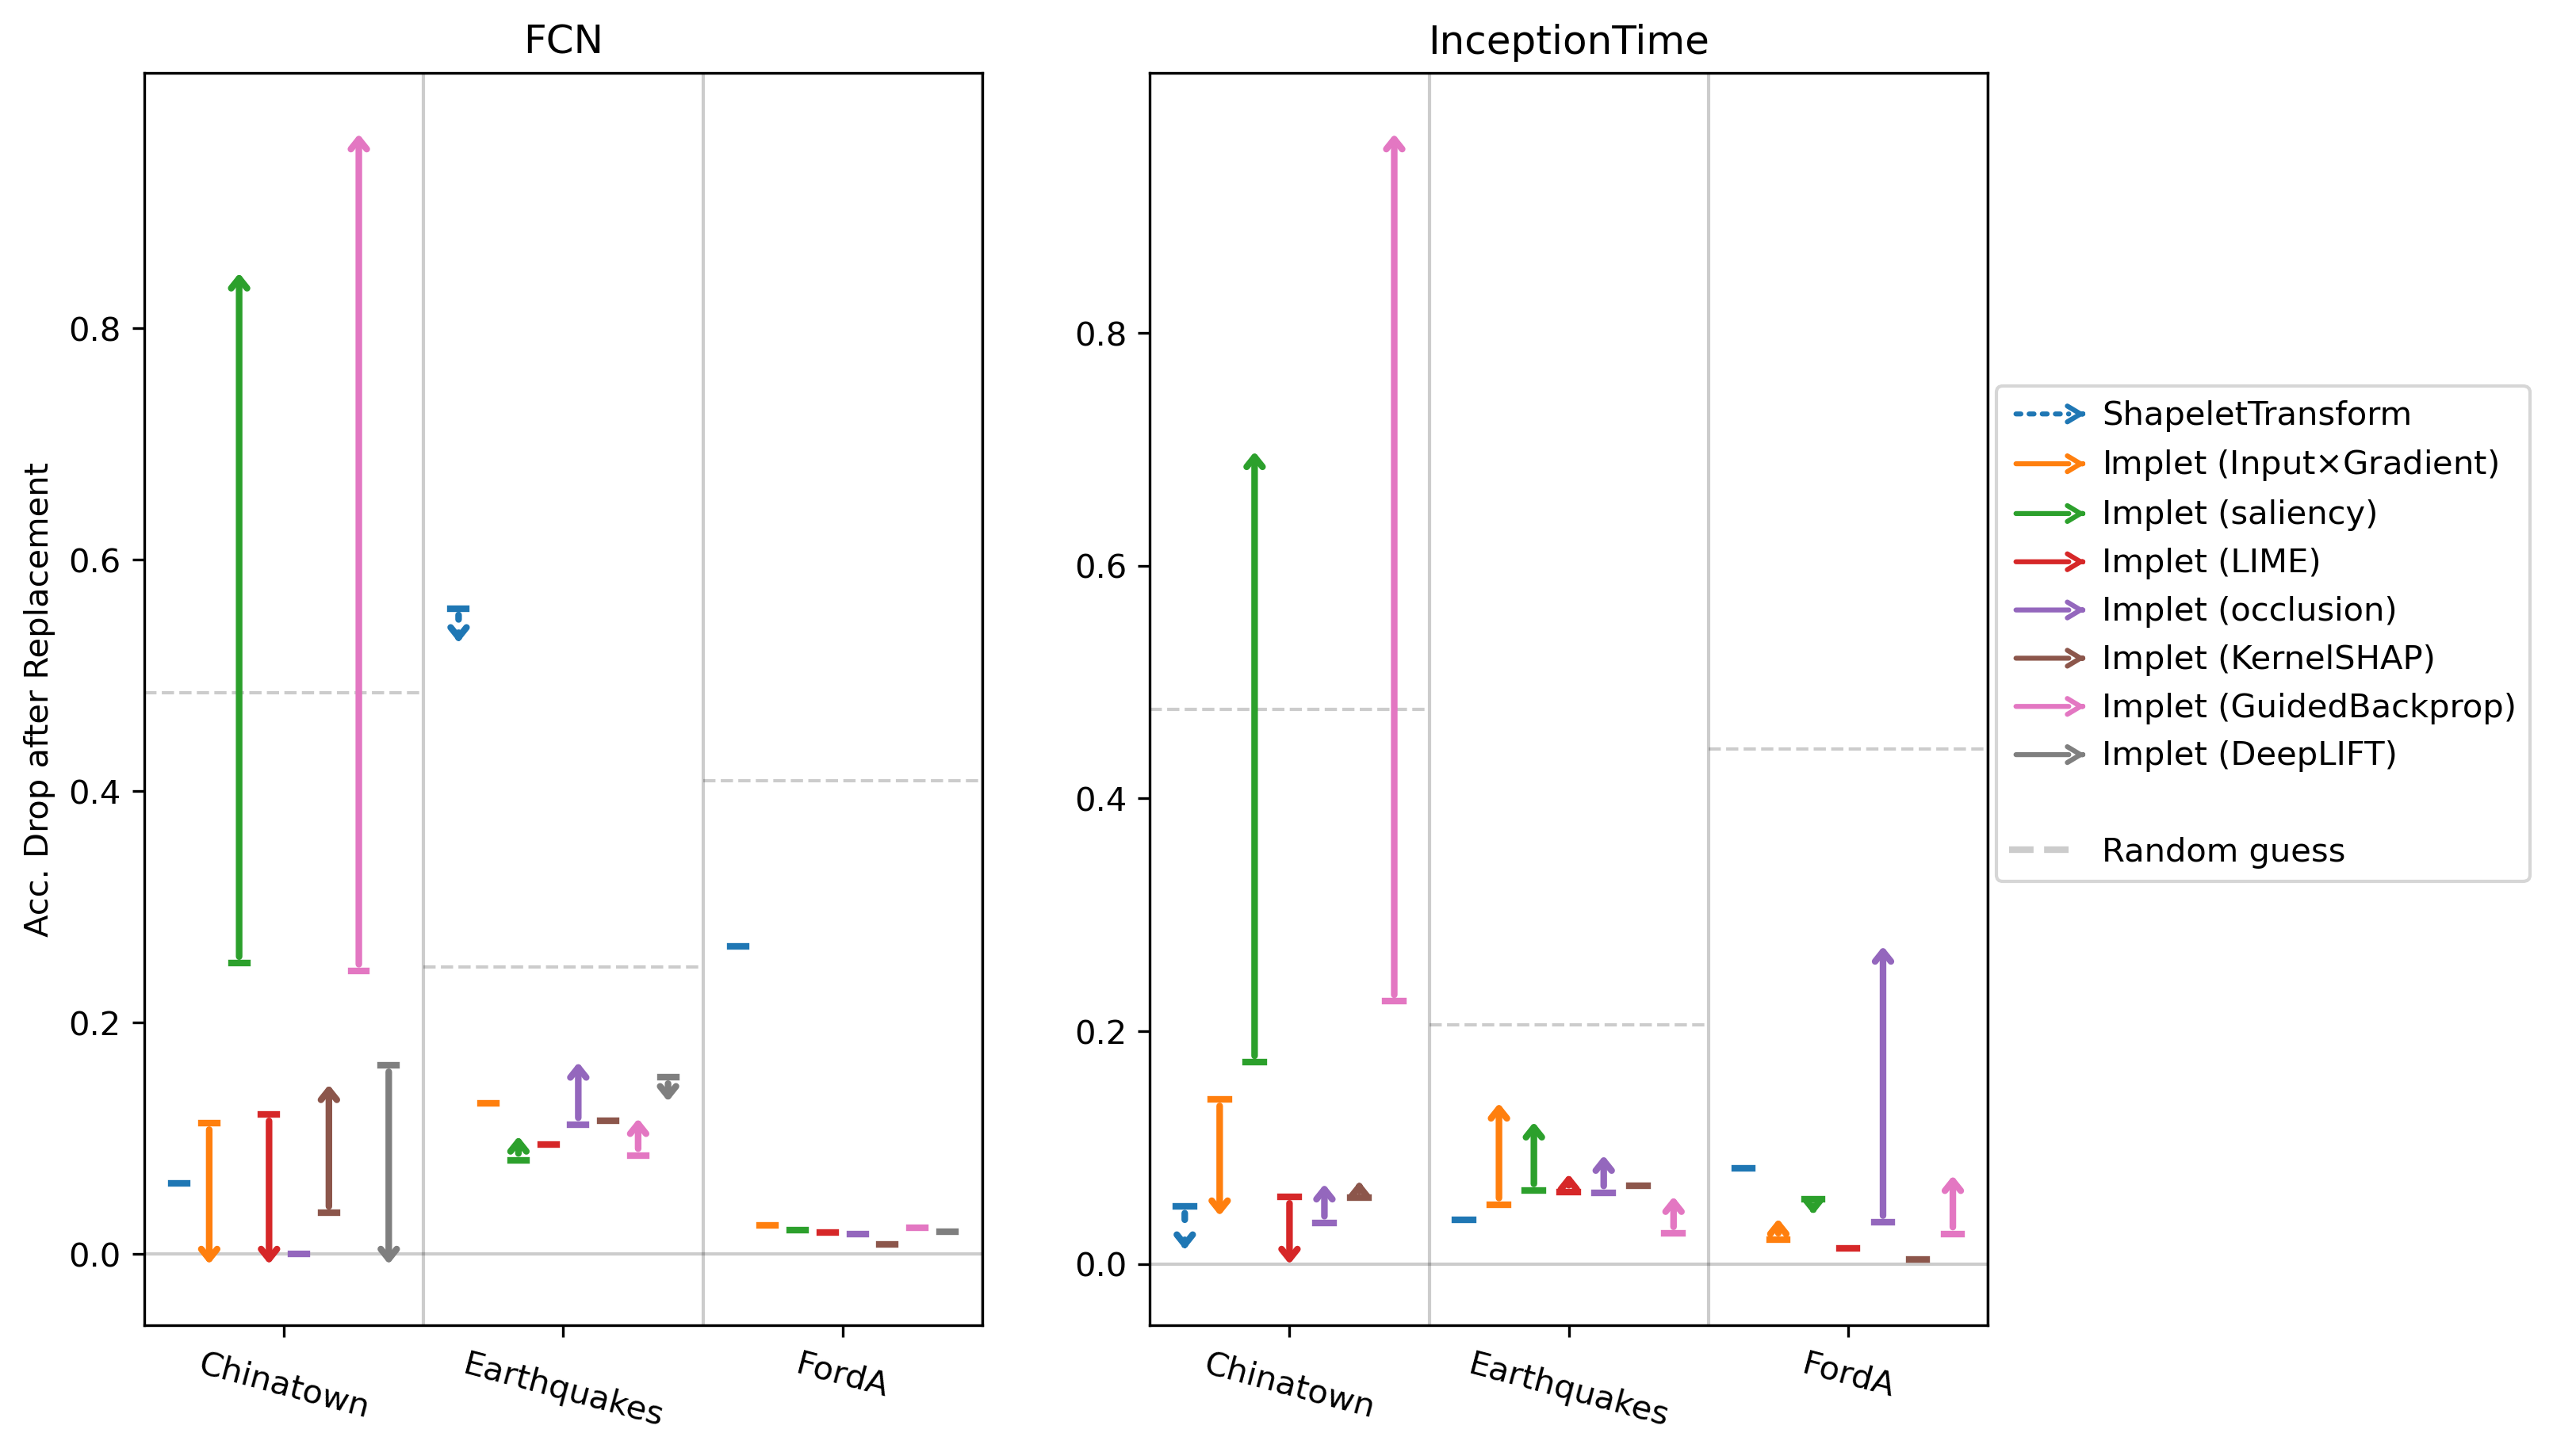

In [88]:
# sns.pointplot(df[(df['model_name'] == 'FCN') & (df['method_x'] == 'repl_implet')], x='task_name', y='acc_drop', hue='xai_name_x', dodge=0.6, ls='', marker='o', markersize=5)
# sns.pointplot(df[(df['model_name'] == 'FCN') & (df['method_x'] == 'repl_random_loc')], x='task_name', y='acc_drop', hue='xai_name_x', dodge=0.6, ls='', marker='x', markersize=5)

dodge = 0.75
arrow_thresh = 0.015

arrowstyle = ArrowStyle.CurveB(head_length=0.15, head_width=0.12)
arrowstyle_legend = ArrowStyle.CurveB(head_length=0.2, head_width=0.12)

legend_map = {explainer: explainer for explainer in ['ShapeletTransform'] + xai_names}
del legend_map['DeepLift']
legend_map['KernelShap'] = 'KernelSHAP'
legend_map['Saliency'] = 'saliency'
legend_map['Occlusion'] = 'occlusion'
legend_map['Lime'] = 'LIME'
legend_map['InputXGradient'] = 'Input$\\times$Gradient'
legend_map['DeepLift'] = 'DeepLIFT'

plt.clf()

_task_name_map = {
    'Chinatown': 'Chinatown',
    'Earthquakes': 'Earthquakes',
    'FordA': 'FordA'
}

ylim = (-0.13, 0.93)
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(10, 6 * (ylim[1] - ylim[0]) / 0.93))

for t, model_name in enumerate(['FCN', 'InceptionTime']):
    # fig = plt.figure(dpi=300, figsize=(24, 6))
    # if model_name == 'FCN':
    #     ax = brokenaxes(xlims=((-0.5, 13.5),), ylims=((-0.12, 0.47), (0.55, 0.8)), hspace=.05, d=0.005)
    # else:
    #     ax = brokenaxes(xlims=((-0.5, 13.5),), ylims=((-0.12, 0.57), (0.65, 0.8)), hspace=.05, d=0.005)

    # plot random guess line
    for j, task in enumerate(_task_name_map.values()):
        acc = baseline[(baseline['model_name'] == model_name) & (baseline['task_name'] == task)]['acc_score'].mean()
        axes[t].plot([j - 0.5, j + 0.5], [acc - 0.5, acc - 0.5], lw=1, color='black', alpha=0.2, zorder=-1, ls='--')

    explainers = ['ShapeletTransform'] + xai_names[1:]
    if model_name != 'InceptionTime':
        explainers.append(xai_names[0])
    
    dodge_amounts = np.linspace(-dodge / 2, dodge / 2, len(explainers))
    arrow_tail_width = dodge / len(explainers) / 2 * 0.6
    
    for i, explainer in enumerate(explainers):
        for j, task in enumerate(_task_name_map.values()):
            data = df[
                (df['model_name'] == model_name)
                & (df['xai_name_x'] == explainer)
                & (df['task_name'] == task)
            ]
            x = j + dodge_amounts[i]

            if data[data['method_x'] == 'repl_implet'].empty:
                axes[t].plot([x - arrow_tail_width, x + arrow_tail_width], [0, 0], lw=2, color=plt.get_cmap('tab10')(i))
            else:
                y_subseq = data[data['method_x'] == 'repl_implet']['acc_drop'].values[0]
                y_rand = data[data['method_x'] == 'repl_random_loc']['acc_drop'].values[0]

                if task == 'Earthquakes':
                    y_rand += 1 * (y_rand - y_subseq) + 0.1
                    y_subseq += 0.1

                if np.abs(y_subseq - y_rand) < arrow_thresh:
                    y_mean = (y_subseq + y_rand) / 2
                    axes[t].plot([x - arrow_tail_width, x + arrow_tail_width], [y_mean, y_mean], lw=2, color=plt.get_cmap('tab10')(i))

                else:
                    if explainer == 'ShapeletTransform':
                        arrow = FancyArrowPatch((x, y_rand), (x, y_subseq), arrowstyle='-', ls=':',
                                                    mutation_scale=20, color=plt.get_cmap('tab10')(i), lw=2)
                        axes[t].add_patch(arrow)

                        if y_subseq > y_rand:
                            y_start, y_end = y_subseq, y_subseq + 0.02
                        else:
                            y_start, y_end = y_subseq, y_subseq - 0.02
                        
                        arrow_head = FancyArrowPatch((x, y_start), (x, y_end), arrowstyle=arrowstyle, zorder=2,
                                                     mutation_scale=20, color=plt.get_cmap('tab10')(i), lw=2)
                        axes[t].add_patch(arrow_head)
                    else:
                        arrow = FancyArrowPatch((x, y_rand), (x, y_subseq), arrowstyle=arrowstyle,
                                                mutation_scale=20, color=plt.get_cmap('tab10')(i), lw=2)
                        axes[t].add_patch(arrow)
                    axes[t].plot([x - arrow_tail_width, x + arrow_tail_width], [y_rand, y_rand], lw=2, color=plt.get_cmap('tab10')(i))
                

    axes[t].axhline(0, lw=1, color='black', alpha=0.2, zorder=-1)
    for i in range(len(tasks) - 1):
        axes[t].axvline(i + 0.5, lw=1, color='black', alpha=0.2, zorder=-1)
    axes[t].set_xticks(np.arange(len(_task_name_map.values())), _task_name_map.values(), rotation=-15)
    axes[t].set_xlim(-0.5, len(_task_name_map.values()) - 0.5)
    # ax.set_ylim(*ylim)

    axes[t].set_title(model_name)
    ytick_start = ylim[0] - ((ylim[0] + 1e-10) % 0.2) + 0.2
    axes[t].set_yticks(np.arange(ytick_start, ylim[1] + 1e-4, 0.2))
    
# # custom legends
class ArrowHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        if orig_handle.get_linestyle() == 'solid':
            arrow = FancyArrowPatch((0, 3), (25, 3), ls=orig_handle.get_linestyle(), lw=1.5,
                                    arrowstyle=arrowstyle_legend, color=orig_handle.get_edgecolor(), 
                                    mutation_scale=20)
            return [arrow]
        else:
            arrow = FancyArrowPatch((0, 3), (20, 3), arrowstyle='-', ls=orig_handle.get_linestyle(),  lw=1.5,
                                    color=orig_handle.get_edgecolor(), mutation_scale=20)
            arrow_head = FancyArrowPatch((22, 3), (23, 3), arrowstyle=arrowstyle_legend, ls='-', lw=1.5,
                                         color=orig_handle.get_edgecolor(), mutation_scale=20)
            return [arrow, arrow_head]
        
legend_elements = [
    FancyArrowPatch((0, 0), (0, 0), arrowstyle='->',
                    ls=':' if explainer == 'ShapeletTransform' else '-',
                    color=plt.get_cmap('tab10')(i), 
                    label=f'Implet ({legend_map[explainer]})' if explainer != 'ShapeletTransform' else explainer)
    for i, explainer in enumerate(explainers + ['DeepLift'])
]

legend_elements.extend([
    Line2D([0], [0], lw=2, color='white', alpha=0, label=''),
    Line2D([0], [0], lw=2, color='black', alpha=0.2, ls='--', label='Random guess')
])

axes[0].set_ylabel('Acc. Drop after Replacement')
axes[1].legend(handles=legend_elements, handler_map={FancyArrowPatch: ArrowHandler()},
               bbox_to_anchor=(1.01, 0.75), loc='upper left', borderaxespad=0.)
plt.show()
    

### bar plot

In [8]:
df_repl_subseq = df[df['method_x'] == 'repl_implet']
df_repl_rand = df[df['method_x'] == 'repl_random_loc']
df_bar = df_repl_subseq.merge(df_repl_rand, on=['model_name', 'task_name', 'xai_name_x'], how='left')
df_bar['acc_diff'] = df_bar['acc_drop_x'] - df_bar['acc_drop_y']
# df.drop(columns=['acc_drop_x', 'acc_drop_y', 'method_x_x', 'method_x_y'], inplace=True)

for k, v in legend_map.items():
    df_bar.replace(k, v, inplace=True)

df_bar = df_bar[df_bar['xai_name_x'] != 'IntegratedGradients']

df_bar = df_bar[df_bar['task_name'] != 'GunPointGender']

df_bar

,model_name,task_name,xai_name_x,method_x_x,acc_drop_x,method_x_y,acc_drop_y,acc_diff
0,FCN,Chinatown,DeepLIFT,repl_implet,-0.014577,repl_random_loc,-0.014577,0.000000
1,FCN,Chinatown,GuidedBackprop,repl_implet,0.021469,repl_random_loc,-0.010507,0.031977
2,FCN,Chinatown,Input$\times$Gradient,repl_implet,-0.014577,repl_random_loc,-0.014577,0.000000
3,FCN,Chinatown,KernelSHAP,repl_implet,-0.014577,repl_random_loc,-0.014577,0.000000
4,FCN,Chinatown,LIME,repl_implet,-0.014577,repl_random_loc,-0.014577,0.000000
...,...,...,...,...,...,...,...,...
201,InceptionTime,TwoLeadECG,KernelSHAP,repl_implet,0.022619,repl_random_loc,-0.000297,0.022917
202,InceptionTime,TwoLeadECG,LIME,repl_implet,0.111789,repl_random_loc,0.016583,0.095205
203,InceptionTime,TwoLeadECG,occlusion,repl_implet,0.127888,repl_random_loc,0.088499,0.039388
204,InceptionTime,TwoLeadECG,saliency,repl_implet,0.204012,repl_random_loc,0.151117,0.052895


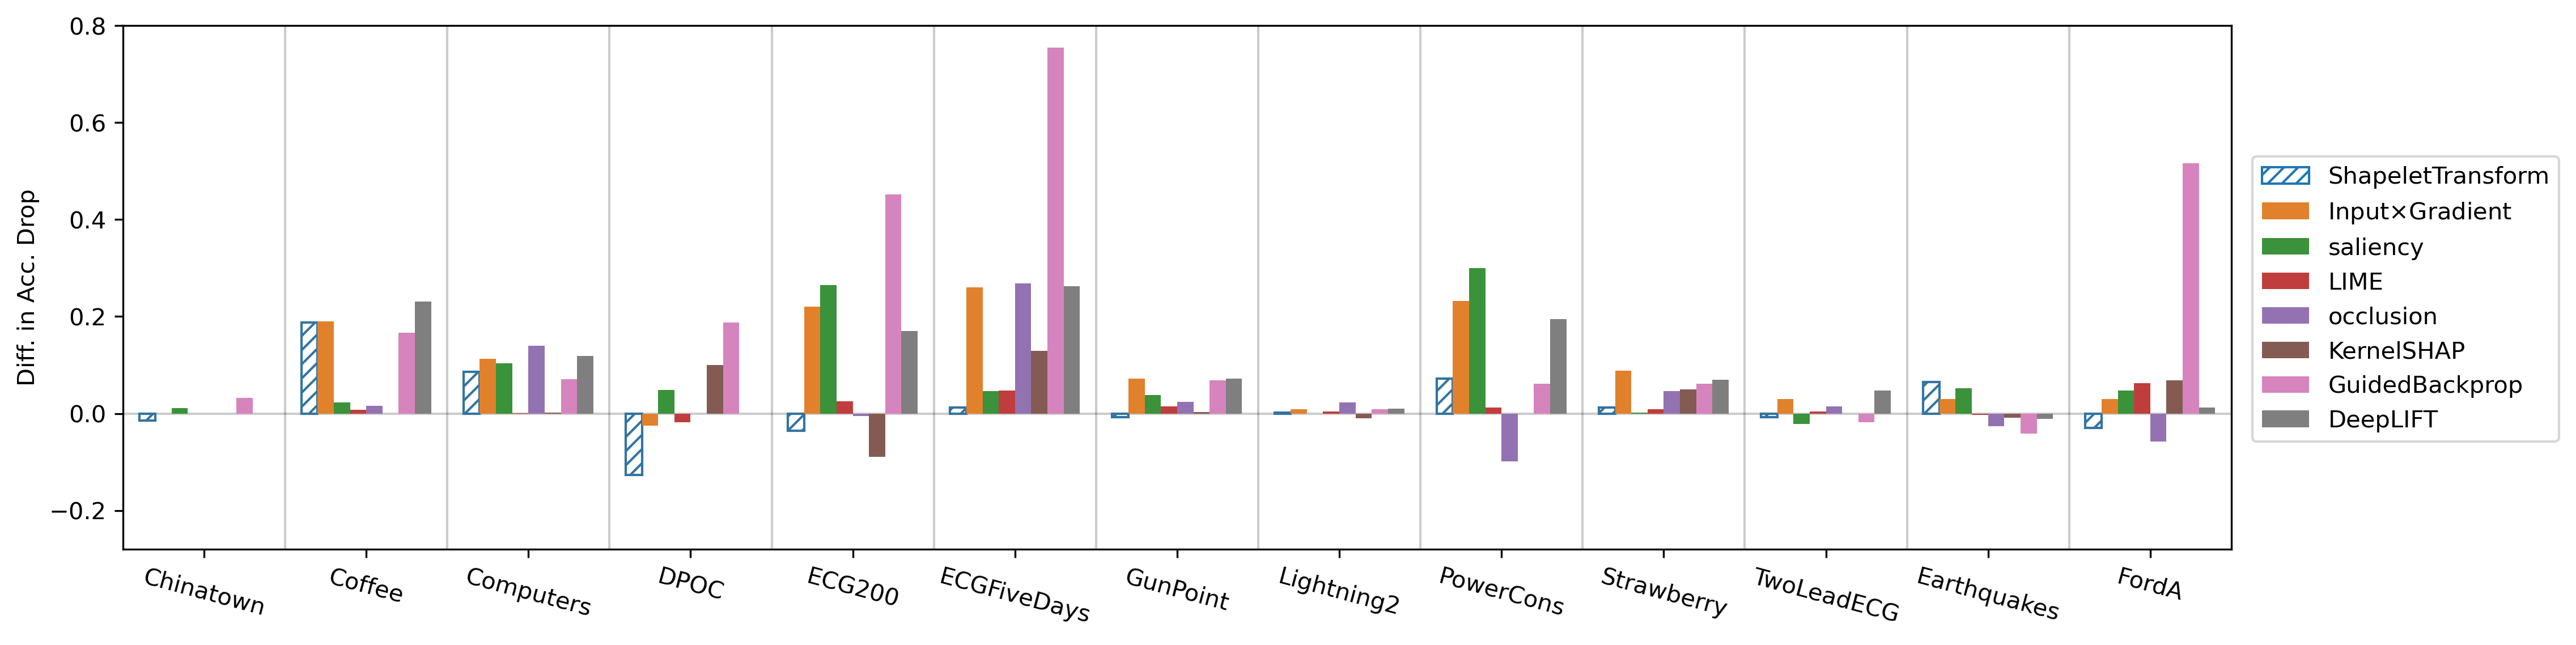

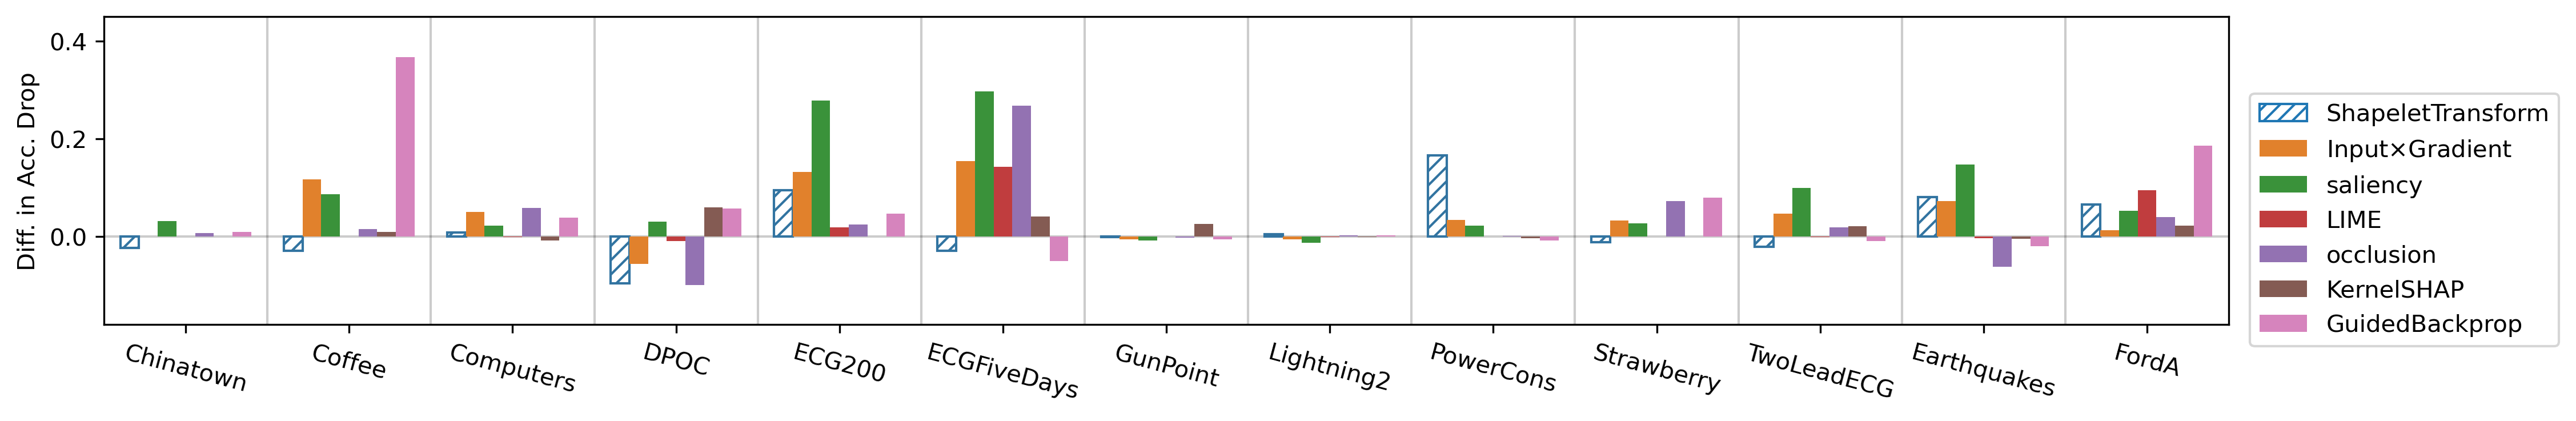

In [9]:
for model_name in ['FCN', 'InceptionTime']:
    ylim = (-0.28, 0.8) if model_name == 'FCN' else (-0.18, 0.45)    
    fig, ax = plt.subplots(dpi=300, figsize=(16, 4 * (ylim[1] - ylim[0]) / 1.08))
    hue_order = legend_map.values()
    if model_name == 'InceptionTime':
        hue_order = [v for v in hue_order if v != 'DeepLIFT']
    bars = sns.barplot(df_bar[df_bar['model_name'] == model_name], x='task_name', y='acc_diff', hue='xai_name_x', hue_order=hue_order)
    
    for bar in bars.patches[:len(tasks)]:
        bar.set_hatch('////')
        bar.set_edgecolor(bar.get_facecolor())
        bar.set_facecolor('white')
    
    plt.ylim(*ylim)
    ytick_start = ylim[0] - ((ylim[0] + 1e-10) % 0.2) + 0.2
    plt.yticks(np.arange(ytick_start, ylim[1], 0.2))
    plt.axhline(0, lw=1, color='black', alpha=0.2, zorder=-1)
    for i in range(len(tasks) - 1):
        plt.axvline(i + 0.5, lw=1, color='black', alpha=0.2, zorder=-1)
    plt.xticks(np.arange(len(tasks)), task_name_map.values(), rotation=-15)
    handles, labels = ax.get_legend_handles_labels()
    handles[0] = mpatches.Patch(color=plt.get_cmap('tab10')(0), label=labels[0])
    handles[0].set_hatch('////')
    handles[0].set_edgecolor(handles[0].get_facecolor())
    handles[0].set_facecolor('white')
    plt.legend(handles, labels, bbox_to_anchor=(1.01, 0.75), loc='upper left', borderaxespad=0.)    
    plt.xlabel('')
    plt.ylabel('Diff. in Acc. Drop')
    plt.show()

# shapelet len

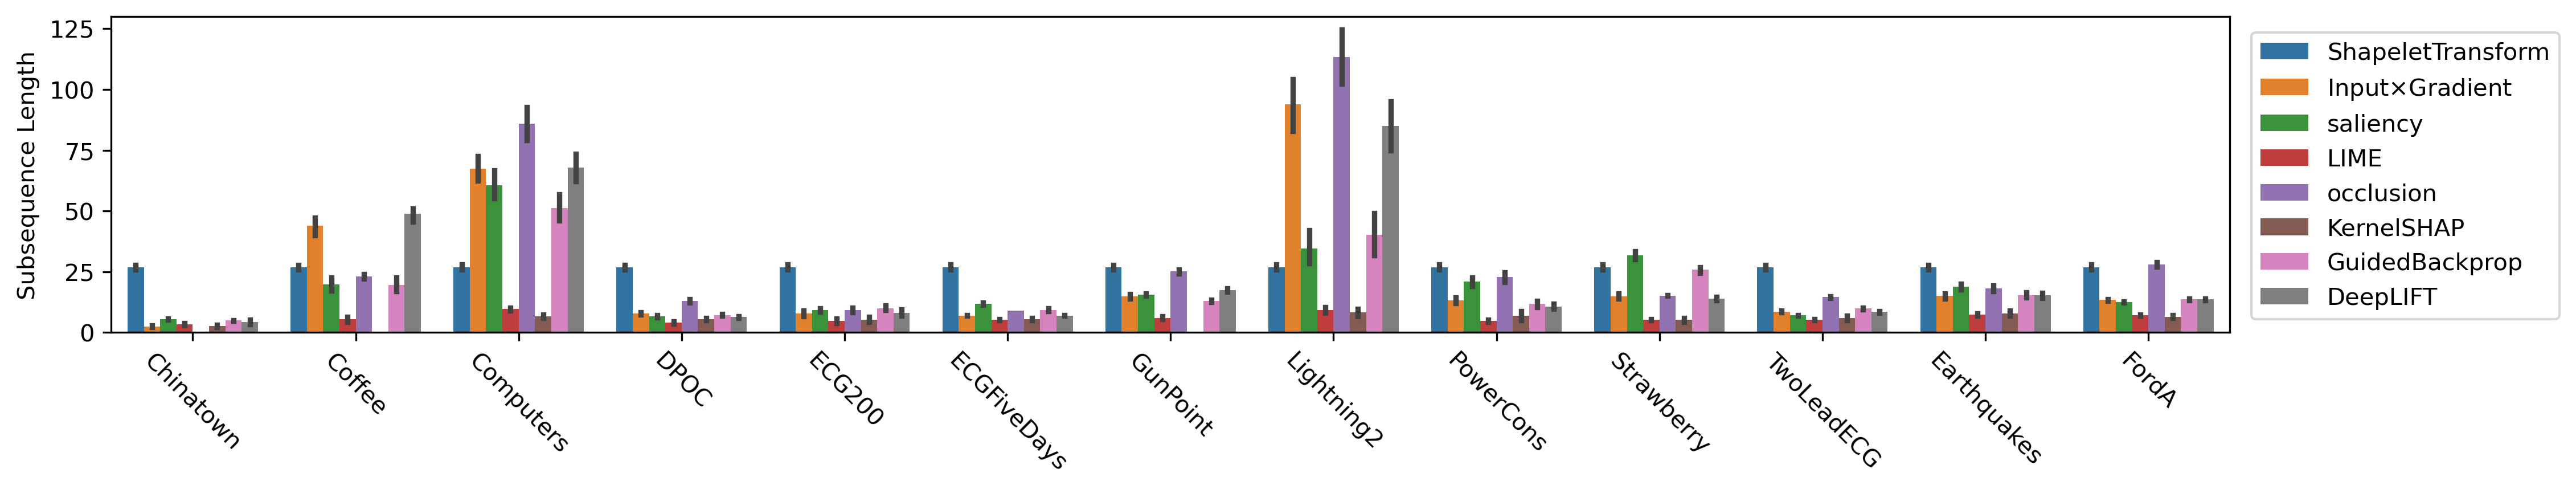

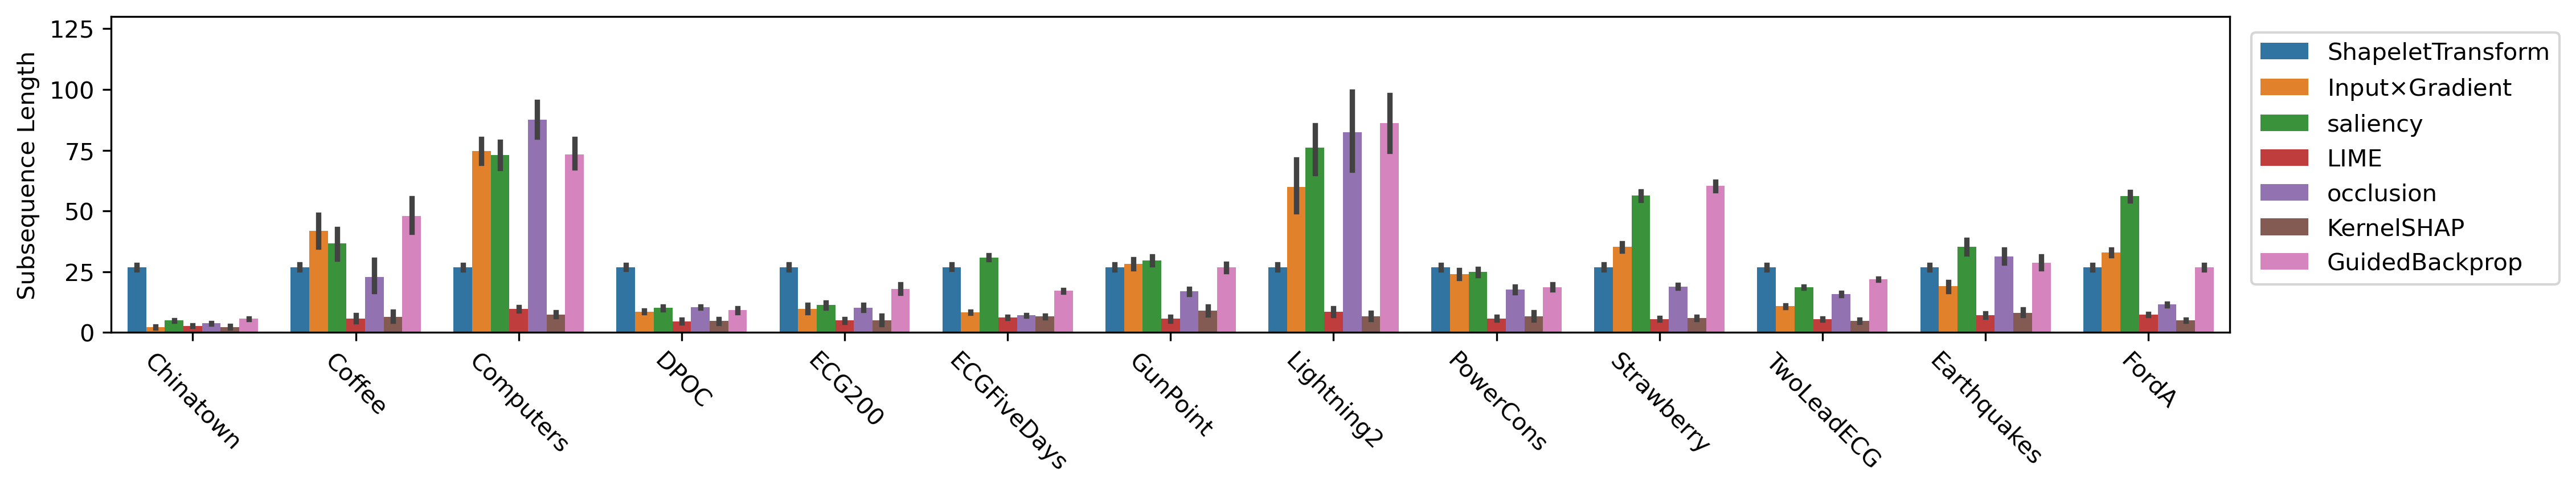

In [10]:
data = defaultdict(lambda: [])

for model_name in ['FCN', 'InceptionTime']:
    for task in tasks:
        for explainer in xai_names:
            implet_filepath = f'./output/{model_name}/{task}/{explainer}/implets.pkl'
            if os.path.isfile(implet_filepath):
                with open(implet_filepath, 'rb') as f:
                    implets = pickle.load(f)

                if isinstance(implets, dict):
                    implets = sum(implets.values(), [])
                
                for _, _, _, _, start, end in implets:
                    data['model_name'].append(model_name)
                    data['task'].append(task_name_map[task])
                    data['explainer'].append(legend_map[explainer])
                    data['subseq_len'].append(end - start + 1)

# load shapelets
for task in tasks:
    shaplet_filepath = f'./output/ST/{task}/shapelet.pkl'
    with open(implet_filepath, 'rb') as f:
        shapelets = pickle.load(f)
        
    if isinstance(shapelets, dict):
        shapelets = sum(shapelets.values(), [])
        
    for _, _, _, _, start, end in shapelets:
        data['model_name'].append(np.nan)
        data['task'].append(task_name_map[task])
        data['explainer'].append('ShapeletTransform')
        data['subseq_len'].append(end - start + 1)

df_len = pd.DataFrame(data)
df_len.to_csv('./output/implet_len.csv')

for model_name in ['FCN', 'InceptionTime']:
    plt.figure(dpi=300, figsize=(16, 2.4))
    hue_order = legend_map.values()
    if model_name == 'InceptionTime':
        hue_order = [v for v in hue_order if v != 'DeepLIFT']
    sns.barplot(df_len[(df_len['model_name'] == model_name) | df_len['model_name'].isnull()], x='task', y='subseq_len', hue='explainer', hue_order=hue_order)
    plt.xticks(np.arange(len(tasks)), task_name_map.values(), rotation=-45)
    plt.ylim(0, 130)
    plt.xlabel('')
    plt.ylabel('Subsequence Length')
    plt.legend(bbox_to_anchor=(1.01, 0.95), loc='upper left', borderaxespad=0.)
    plt.show()

# model acc

In [11]:
for task in baseline['task_name'].unique():
    print(baseline[baseline['task_name'] == task])


# plt.figure(dpi=300, figsize=(16, 2.4))
# hue_order = legend_map.values()
# if model_name == 'InceptionTime':
#     hue_order = [v for v in hue_order if v != 'DeepLIFT']
# sns.barplot(baseline, x='task_name', y='acc_score', hue='model_name')
# plt.xticks(np.arange(len(tasks)), task_name_map.values(), rotation=-45)
# plt.ylim(0, 130)
# plt.xlabel('')
# plt.ylabel('Subsequence Length')
# plt.legend(bbox_to_anchor=(1.01, 0.95), loc='upper left', borderaxespad=0.)
# plt.show()

         model_name task_name xai_name method  acc_score
0               FCN  GunPoint      NaN    ori   1.000000
726   InceptionTime  GunPoint      NaN    ori   0.986667
3328            FCN  GunPoint      NaN    ori   1.000000
0               FCN  GunPoint      NaN    ori   1.000000
294   InceptionTime  GunPoint      NaN    ori   0.986667
         model_name task_name xai_name method  acc_score
121             FCN    ECG200      NaN    ori       0.86
847   InceptionTime    ECG200      NaN    ori       0.89
3370            FCN    ECG200      NaN    ori       0.86
42              FCN    ECG200      NaN    ori       0.86
336   InceptionTime    ECG200      NaN    ori       0.89
         model_name task_name xai_name method  acc_score
242             FCN      DPOC      NaN    ori   0.768116
968   InceptionTime      DPOC      NaN    ori   0.746377
3391            FCN      DPOC      NaN    ori   0.768116
63              FCN      DPOC      NaN    ori   0.768116
357   InceptionTime      DPOC  

In [12]:
mean_acc_st = df_st.groupby(['task_name', 'xai_name', 'method'])['acc_score'].mean()
df_st_ = df_st.merge(mean_acc_st, on=['task_name', 'xai_name', 'method'])
df_st_[df_st_['task_name'] == 'GunPoint']


,model_name,task_name,xai_name,method,acc_score_x,acc_score_y
0,FCN,GunPoint,ShapeletTransform,repl_implet,0.760399,0.744426
1,FCN,GunPoint,ShapeletTransform,repl_implet,0.752080,0.744426
2,FCN,GunPoint,ShapeletTransform,repl_implet,0.753744,0.744426
3,FCN,GunPoint,ShapeletTransform,repl_implet,0.750416,0.744426
4,FCN,GunPoint,ShapeletTransform,repl_implet,0.740433,0.744426
5,FCN,GunPoint,ShapeletTransform,repl_implet,0.750416,0.744426
6,FCN,GunPoint,ShapeletTransform,repl_implet,0.735441,0.744426
7,FCN,GunPoint,ShapeletTransform,repl_implet,0.770383,0.744426
8,FCN,GunPoint,ShapeletTransform,repl_implet,0.753744,0.744426
9,FCN,GunPoint,ShapeletTransform,repl_implet,0.758735,0.744426


# Half Dataset

In [13]:
df_half = pd.read_csv(f'output/half_dataset_test_new.csv')

df_half.replace('DistalPhalanxOutlineCorrect', 'DPOC', inplace=True)
df_half.replace('GunPointMaleVersusFemale', 'GunPointGender', inplace=True)

df_half = df_half[(df_half['mode'] == 'single') | (df_half['method'] == 'ori')]
df_half.drop(columns=['mode'], inplace=True)

# df_half.head()
print(len(df_half[df_half['acc_score'].isnull()]))
print(len(df_half))

780
8497


In [14]:
baseline = df_half.query('method == "ori"')
df_half = df_half.query('method != "ori"')
baseline.head()

,model_name,task_name,xai_name,method,implet_src,acc_score
80,FCN,Coffee,NaN,ori,NaN,1.00
161,FCN,Coffee,NaN,ori,NaN,1.00
242,FCN,Computers,NaN,ori,NaN,0.84
323,FCN,Coffee,NaN,ori,NaN,1.00
404,FCN,Computers,NaN,ori,NaN,0.84


In [15]:
df_half = df_half.merge(baseline, on=['model_name', 'task_name'], how='left')
null_idx = df_half['acc_score_x'].isnull()
df_half.loc[null_idx, 'acc_score_x'] = df_half[null_idx]['acc_score_y']
df_half['acc_drop'] = df_half['acc_score_y'] - df_half['acc_score_x']
# df_half.drop(columns=['xai_name_y', 'method_y', 'acc_score_x', 'acc_score_y', 'implet_src_y'], inplace=True)
df_half.head()

,model_name,task_name,xai_name_x,method_x,implet_src_x,acc_score_x,xai_name_y,method_y,implet_src_y,acc_score_y,acc_drop
0,FCN,Coffee,Saliency,repl_implet,real,1.000000,NaN,ori,NaN,1.0,0.000000
1,FCN,Coffee,Saliency,repl_implet,real,1.000000,NaN,ori,NaN,1.0,0.000000
2,FCN,Coffee,Saliency,repl_implet,real,1.000000,NaN,ori,NaN,1.0,0.000000
3,FCN,Coffee,Saliency,repl_implet,real,1.000000,NaN,ori,NaN,1.0,0.000000
4,FCN,Coffee,Saliency,repl_random_loc,real,0.923077,NaN,ori,NaN,1.0,0.076923


In [16]:
df_half = df_half.groupby(['model_name', 'task_name', 'xai_name_x', 'method_x', 'implet_src_x'])['acc_drop'].mean().reset_index()
df_half.head()

,model_name,task_name,xai_name_x,method_x,implet_src_x,acc_drop
0,FCN,Chinatown,DeepLift,repl_implet,ident,0.0
1,FCN,Chinatown,DeepLift,repl_implet,real,0.0
2,FCN,Chinatown,DeepLift,repl_random_loc,ident,0.0
3,FCN,Chinatown,DeepLift,repl_random_loc,real,0.0
4,FCN,Chinatown,GuidedBackprop,repl_implet,ident,0.0


In [17]:
def split_arrow(arrow, color="C0",
                ls_tail=":", ls_head="-",lw_tail=2, lw_head=2):  
    v = arrow.get_path().vertices
    c = arrow.get_path().codes
    p = matplotlib.path.Path(v, c)
    pp = mpatches.PathPatch(p, color=color, linestyle=ls_tail, lw=lw_tail)
    arrow.axes.add_patch(pp)
    arrow.remove()

    # print(arrow.get_path().vertices)
    # print(arrow.get_path().codes)
    
    # v1 = arrow.get_path().vertices[0:3,:]
    # c1 = arrow.get_path().codes[0:3]
    # p1 = matplotlib.path.Path(v1,c1)
    # pp1 = mpatches.PathPatch(p1, color=color, linestyle=ls_tail, 
    #                         fill=False, lw=lw_tail)
    # arrow.axes.add_patch(pp1)

    # v2 = arrow.get_path().vertices[3:,:]
    # c2 = arrow.get_path().codes[3:]
    # # c2[0] = 1
    # p2 = matplotlib.path.Path(v2,c2)
    # pp2 = mpatches.PathPatch(p2, color=color, lw=lw_head, linestyle=ls_head)
    # arrow.axes.add_patch(pp2)
    # arrow.remove()


<Figure size 640x480 with 0 Axes>

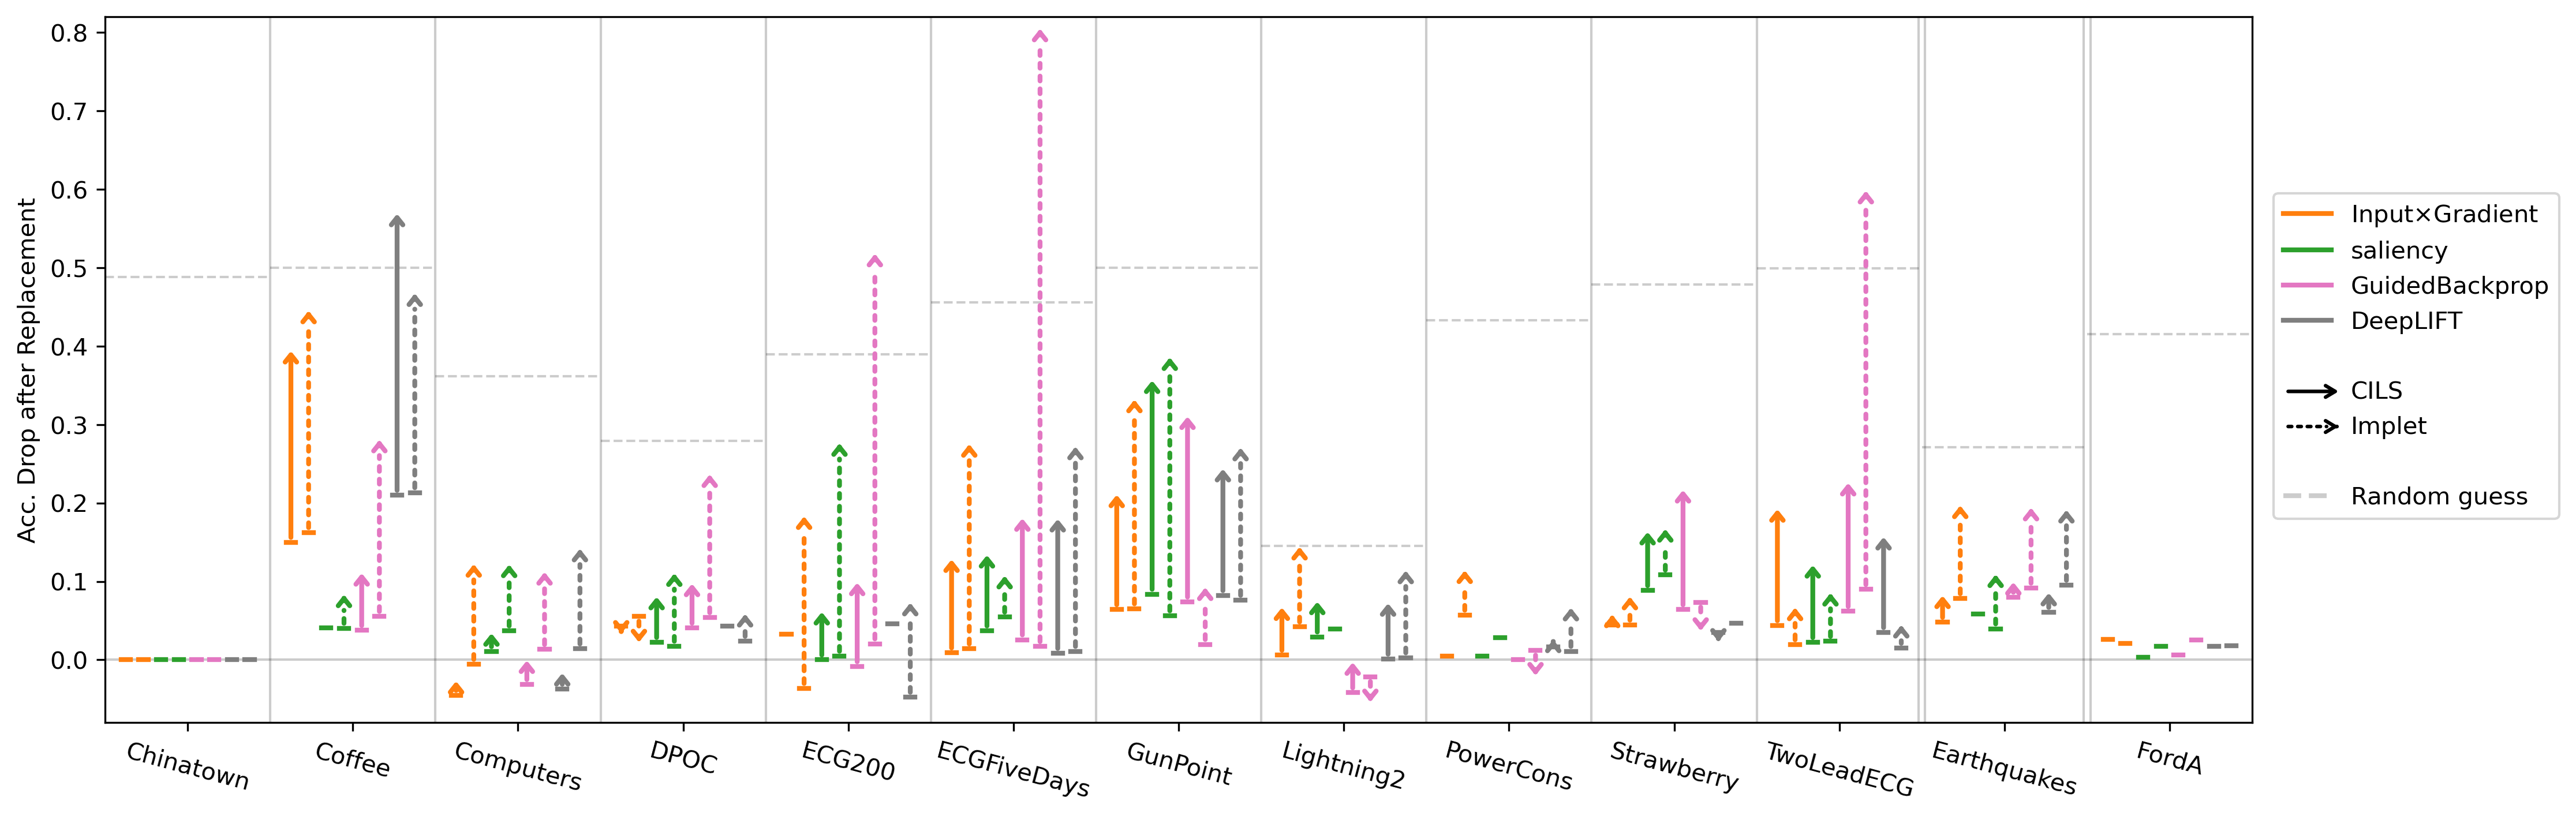

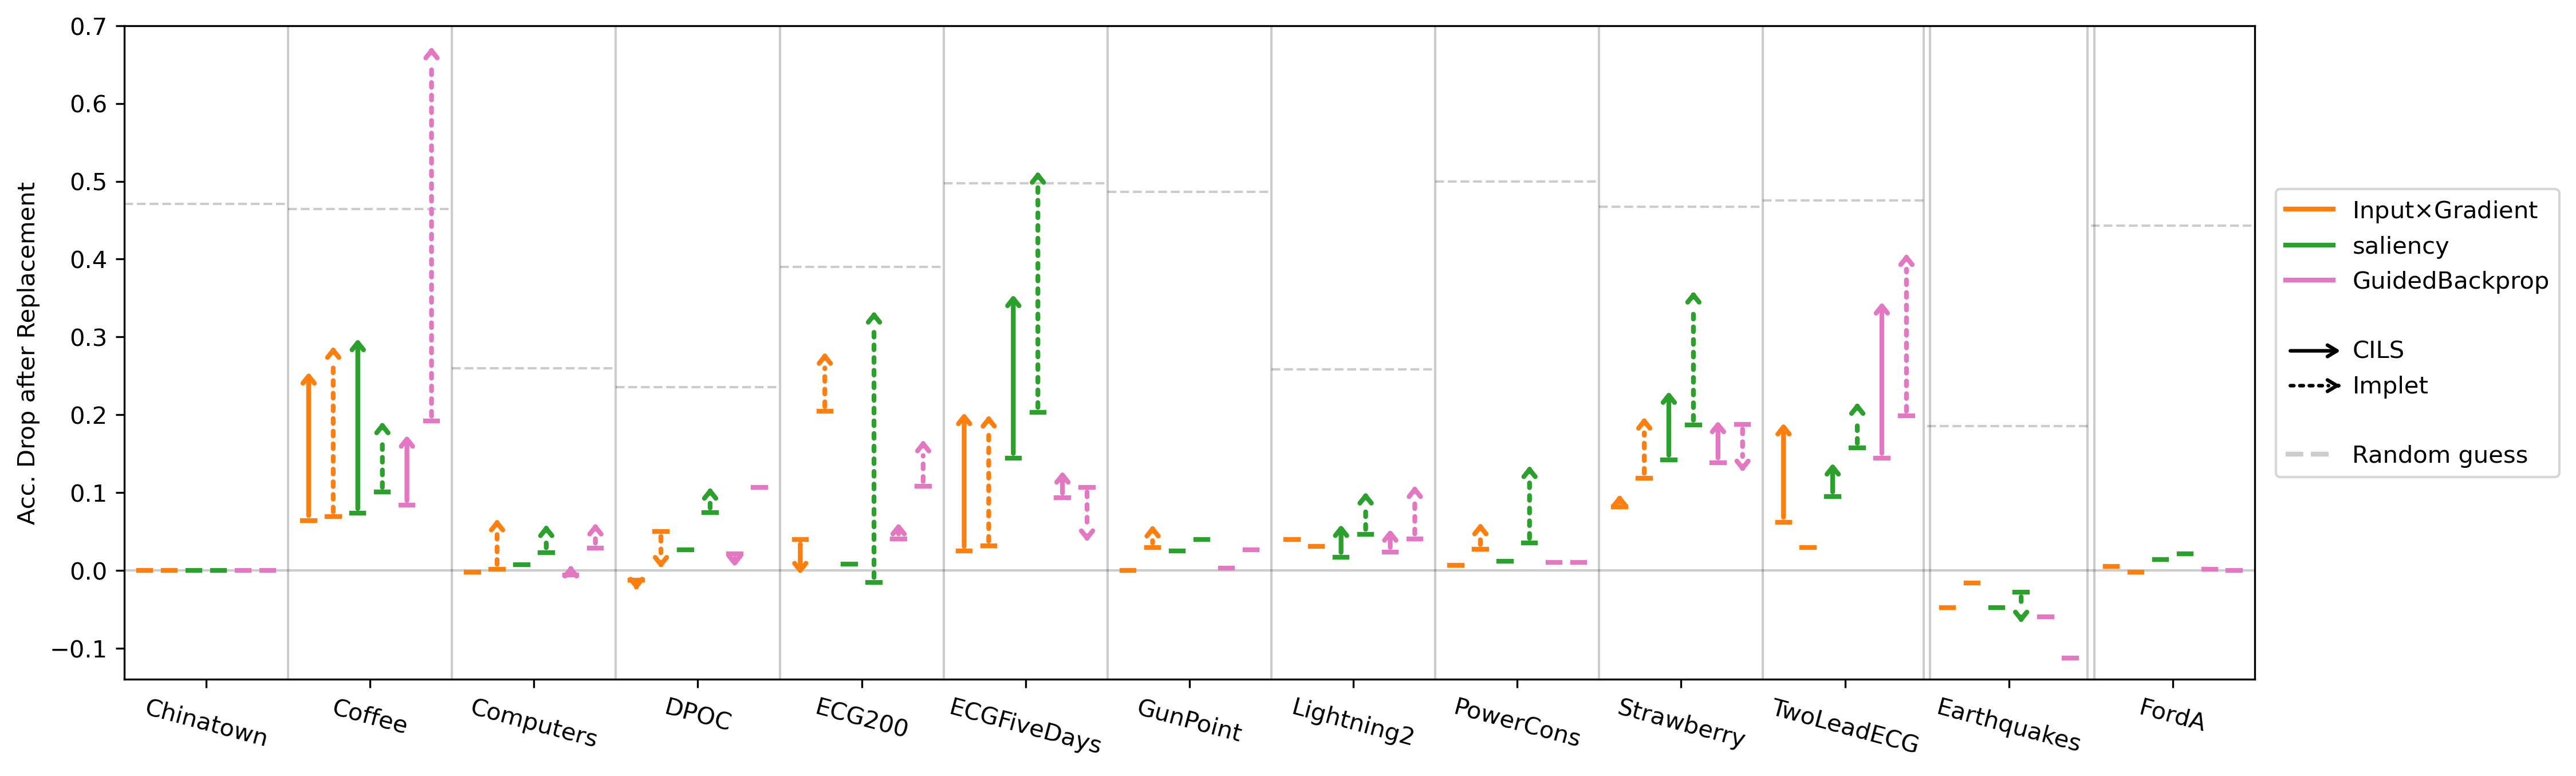

In [18]:
dodge = 0.75
arrow_thresh = 0.015

arrowstyle = ArrowStyle.CurveB(head_length=0.15, head_width=0.12)
arrowstyle_legend = ArrowStyle.CurveB(head_length=0.2, head_width=0.12)

legend_map = {explainer: explainer for explainer in explainers}
legend_map['DeepLift'] = 'DeepLIFT'
legend_map['KernelShap'] = 'KernelSHAP'
legend_map['Saliency'] = 'saliency'
legend_map['Occlusion'] = 'occlusion'
legend_map['Lime'] = 'LIME'
legend_map['InputXGradient'] = 'Input$\\times$Gradient'

explainer_subset = ['InputXGradient', 'Saliency', 'GuidedBackprop', 'DeepLift']
explainer_color_idx = [1, 2, 6, 7]

plt.clf()

for model_name in ['FCN', 'InceptionTime']:
    ylim = (-0.08, 0.82) if model_name == 'FCN' else (-0.14, 0.7)
    fig, ax = plt.subplots(dpi=300, figsize=(16, 6 * (ylim[1] - ylim[0]) / 1.02))

    explainers = xai_names[1:]
    if model_name != 'InceptionTime':
        explainers.append(xai_names[0])
    explainers = [exp for exp in explainers if exp in explainer_subset]

    dodge_amounts = np.linspace(-dodge / 2, dodge / 2, len(explainers) * 2)
    arrow_tail_width = dodge / len(explainers) / 2 / 2 * 0.6

    # plot random guess line
    for j, task in enumerate(task_name_map.values()):
        acc = baseline[(baseline['model_name'] == model_name) & (baseline['task_name'] == task)]['acc_score'].mean()
        ax.plot([j - 0.5, j + 0.5], [acc - 0.5, acc - 0.5], lw=1, color='black', alpha=0.2, zorder=-1, ls='--')
    
    for i, explainer in enumerate(explainers):
        for j, task in enumerate(task_name_map.values()):
            data = df_half.query(f'model_name == "{model_name}" and xai_name_x == "{explainer}" and task_name == "{task}"')

            for k, implet_src in enumerate(['ident', 'real']):
                
                x = j + dodge_amounts[i * 2 + k]
    
                if data.query(f'method_x == "repl_implet" and implet_src_x == "{implet_src}"').empty:
                    ax.plot([x - arrow_tail_width, x + arrow_tail_width], [0, 0], lw=2, 
                            color=plt.get_cmap('tab10')(explainer_color_idx[i]))
                else:
                    y_subseq = data.query(f'method_x == "repl_implet" and implet_src_x == "{implet_src}"')['acc_drop'].values[0]
                    y_rand = data.query(f'method_x == "repl_random_loc" and implet_src_x == "{implet_src}"')['acc_drop'].values[0]
    
                    if np.abs(y_subseq - y_rand) < arrow_thresh:
                        y_mean = (y_subseq + y_rand) / 2
                        ax.plot([x - arrow_tail_width, x + arrow_tail_width], [y_mean, y_mean], lw=2, 
                                color=plt.get_cmap('tab10')(explainer_color_idx[i]))
    
                    else:
                        if k == 0:
                            arrow = FancyArrowPatch((x, y_rand), (x, y_subseq), arrowstyle=arrowstyle,
                                                    mutation_scale=20, color=plt.get_cmap('tab10')(explainer_color_idx[i]), lw=2)
                            ax.add_patch(arrow)

                        else:
                            arrow = FancyArrowPatch((x, y_rand), (x, y_subseq), arrowstyle='-', ls=':',
                                                    mutation_scale=20, color=plt.get_cmap('tab10')(explainer_color_idx[i]), lw=2)
                            ax.add_patch(arrow)

                            if y_subseq > y_rand:
                                y_start, y_end = y_subseq, y_subseq + 0.02
                            else:
                                y_start, y_end = y_subseq, y_subseq - 0.02
                            
                            arrow_head = FancyArrowPatch((x, y_start), (x, y_end), arrowstyle=arrowstyle, zorder=2,
                                                         mutation_scale=20, color=plt.get_cmap('tab10')(explainer_color_idx[i]), lw=2)
                            ax.add_patch(arrow_head)

                        
                        ax.plot([x - arrow_tail_width, x + arrow_tail_width], [y_rand, y_rand], lw=2, 
                                color=plt.get_cmap('tab10')(explainer_color_idx[i]))
                

    ax.axhline(0, lw=1, color='black', alpha=0.2, zorder=-1)
    for i in range(len(tasks) - 1):
        if i == 10 or i == 11:
            ax.axvline(i + 0.48, lw=1, color='black', alpha=0.2, zorder=-1)
            ax.axvline(i + 0.52, lw=1, color='black', alpha=0.2, zorder=-1)
        else:
            ax.axvline(i + 0.5, lw=1, color='black', alpha=0.2, zorder=-1)
    ax.set_xticks(np.arange(len(tasks)), task_name_map.values(), rotation=-15)
    ax.set_xlim(-0.5, 12.5)
    ax.set_ylim(*ylim)

    ax.set_ylabel('Acc. Drop after Replacement')
    
    # # custom legends
    # class ArrowHandler(HandlerBase):
    #     def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
    #         arrow = mpatches.FancyArrow(0, 3, 25, 0, color=orig_handle.get_edgecolor(), width=1, length_includes_head=True)
    #         return [arrow]

    class ArrowHandler(HandlerBase):
        def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
            if orig_handle.get_linestyle() == 'solid':
                arrow = FancyArrowPatch((0, 3), (25, 3), ls=orig_handle.get_linestyle(), lw=1.5,
                                        arrowstyle=arrowstyle_legend, color=orig_handle.get_edgecolor(), 
                                        mutation_scale=20)
                return [arrow]
            else:
                arrow = FancyArrowPatch((0, 3), (20, 3), arrowstyle='-', ls=orig_handle.get_linestyle(),  lw=1.5,
                                        color=orig_handle.get_edgecolor(), mutation_scale=20)
                arrow_head = FancyArrowPatch((22, 3), (23, 3), arrowstyle=arrowstyle_legend, ls='-', lw=1.5,
                                             color=orig_handle.get_edgecolor(), mutation_scale=20)
                return [arrow, arrow_head]
                
            
    legend_elements = [
        # FancyArrowPatch((0, 0), (0, 0), arrowstyle='->', 
        #                 color=plt.get_cmap('tab10')(explainer_color_idx[i]),
        #                 label=f'{legend_map[explainer]}' if explainer != 'ShapeletTransform' else explainer)
        Line2D([0], [0], lw=2, color=plt.get_cmap('tab10')(explainer_color_idx[i]),
                         label=f'{legend_map[explainer]}' if explainer != 'ShapeletTransform' else explainer)
        for i, explainer in enumerate(explainers)
    ]

    legend_elements.extend([
        FancyArrowPatch((0, 0), (0, 0), arrowstyle='->', color='white', alpha=0, label=''),
        FancyArrowPatch((0, 0), (0, 0), arrowstyle='->', color='black', label='CILS'),
        FancyArrowPatch((0, 0), (0, 0), arrowstyle='->', color='black', ls=':', label='Implet'),
        Line2D([0], [0], lw=2, color='white', alpha=0, label=''),
        Line2D([0], [0], lw=2, color='black', alpha=0.2, ls='--', label='Random guess')
    ])

    ax.legend(handles=legend_elements, handler_map={FancyArrowPatch: ArrowHandler()},
               bbox_to_anchor=(1.01, 0.75), loc='upper left', borderaxespad=0.)
    plt.show()
    

## Half dataset, 2D ablation

In [19]:
df_half = pd.read_csv(f'output/half_dataset_test_new.csv')
df_half_2d = pd.read_csv(f'output/half_dataset_clsterting2dTrue_test_new.csv')
# temp
df_half_2d = df_half_2d.iloc[df_half_2d.shape[0] // 2:]
df_half_2d.replace({'ident': '2d'}, inplace=True)
df_half_2d = df_half_2d[df_half_2d['implet_src'] == '2d']
print(df_half.shape, df_half_2d.shape)

for k, v in legend_map.items():
    df_half.replace(k, v, inplace=True)
    df_half_2d.replace(k, v, inplace=True)

df_half = pd.concat([df_half, df_half_2d])

df_half.replace('DistalPhalanxOutlineCorrect', 'DPOC', inplace=True)
df_half.replace('GunPointMaleVersusFemale', 'GunPointGender', inplace=True)

df_half = df_half[(df_half['mode'] == 'single') | (df_half['method'] == 'ori')]
df_half.drop(columns=['mode'], inplace=True)

baseline = df_half.query('method == "ori"')
df_half = df_half.query('method != "ori"')

df_half = df_half.merge(baseline, on=['model_name', 'task_name'], how='left')
null_idx = df_half['acc_score_x'].isnull()
df_half.loc[null_idx, 'acc_score_x'] = df_half[null_idx]['acc_score_y']
df_half['acc_drop'] = df_half['acc_score_y'] - df_half['acc_score_x']

df_half = df_half.groupby(['model_name', 'task_name', 'xai_name_x', 'method_x', 'implet_src_x'])['acc_drop'].mean().reset_index()

df_half

(16937, 7) (7320, 7)


,model_name,task_name,xai_name_x,method_x,implet_src_x,acc_drop
0,FCN,Chinatown,DeepLIFT,repl_implet,2d,0.000000
1,FCN,Chinatown,DeepLIFT,repl_implet,ident,0.000000
2,FCN,Chinatown,DeepLIFT,repl_implet,real,0.000000
3,FCN,Chinatown,DeepLIFT,repl_random_loc,2d,0.000000
4,FCN,Chinatown,DeepLIFT,repl_random_loc,ident,0.000000
...,...,...,...,...,...,...
1087,InceptionTime,TwoLeadECG,saliency,repl_implet,ident,0.143838
1088,InceptionTime,TwoLeadECG,saliency,repl_implet,real,0.201837
1089,InceptionTime,TwoLeadECG,saliency,repl_random_loc,2d,0.048190
1090,InceptionTime,TwoLeadECG,saliency,repl_random_loc,ident,0.094567


In [20]:
df_repl_subseq = df_half[df_half['method_x'] == 'repl_implet']
df_repl_rand = df_half[df_half['method_x'] == 'repl_random_loc']
df_bar = df_repl_subseq.merge(df_repl_rand, on=['model_name', 'task_name', 'xai_name_x'], how='left')
df_bar['acc_diff'] = df_bar['acc_drop_x'] - df_bar['acc_drop_y']
# df.drop(columns=['acc_drop_x', 'acc_drop_y', 'method_x_x', 'method_x_y'], inplace=True)

df_bar = df_bar[df_bar['xai_name_x'] != 'IntegratedGradients']
df_bar = df_bar[df_bar['task_name'] != 'GunPointGender']

df_bar = df_bar[df_bar['implet_src_x_x'] == df_bar['implet_src_x_y']]
df_bar['xai_name_x'] = df_bar.apply(lambda r: r['xai_name_x'] + ' ' + r['implet_src_x_x'], axis=1)

explainer_subset = ['Input$\\times$Gradient', 'saliency', 'GuidedBackprop', 'DeepLIFT']
explainer_subset_2d = []
for explainer in explainer_subset:
    explainer_subset_2d.append(explainer + ' ident')
    explainer_subset_2d.append(explainer + ' 2d')
    explainer_subset_2d.append(explainer + ' real')

In [21]:
# list(df_bar['xai_name_x'].unique())
df_bar

,model_name,task_name,xai_name_x,method_x_x,implet_src_x_x,acc_drop_x,method_x_y,implet_src_x_y,acc_drop_y,acc_diff
0,FCN,Chinatown,DeepLIFT 2d,repl_implet,2d,0.000000,repl_random_loc,2d,0.000000,0.000000
4,FCN,Chinatown,DeepLIFT ident,repl_implet,ident,0.000000,repl_random_loc,ident,0.000000,0.000000
8,FCN,Chinatown,DeepLIFT real,repl_implet,real,0.000000,repl_random_loc,real,0.000000,0.000000
9,FCN,Chinatown,GuidedBackprop 2d,repl_implet,2d,0.000000,repl_random_loc,2d,0.000000,0.000000
13,FCN,Chinatown,GuidedBackprop ident,repl_implet,ident,0.000000,repl_random_loc,ident,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
1624,InceptionTime,TwoLeadECG,occlusion ident,repl_implet,ident,0.170668,repl_random_loc,ident,0.064949,0.105719
1628,InceptionTime,TwoLeadECG,occlusion real,repl_implet,real,0.127224,repl_random_loc,real,0.089724,0.037500
1629,InceptionTime,TwoLeadECG,saliency 2d,repl_implet,2d,0.075101,repl_random_loc,2d,0.048190,0.026910
1633,InceptionTime,TwoLeadECG,saliency ident,repl_implet,ident,0.143838,repl_random_loc,ident,0.094567,0.049271


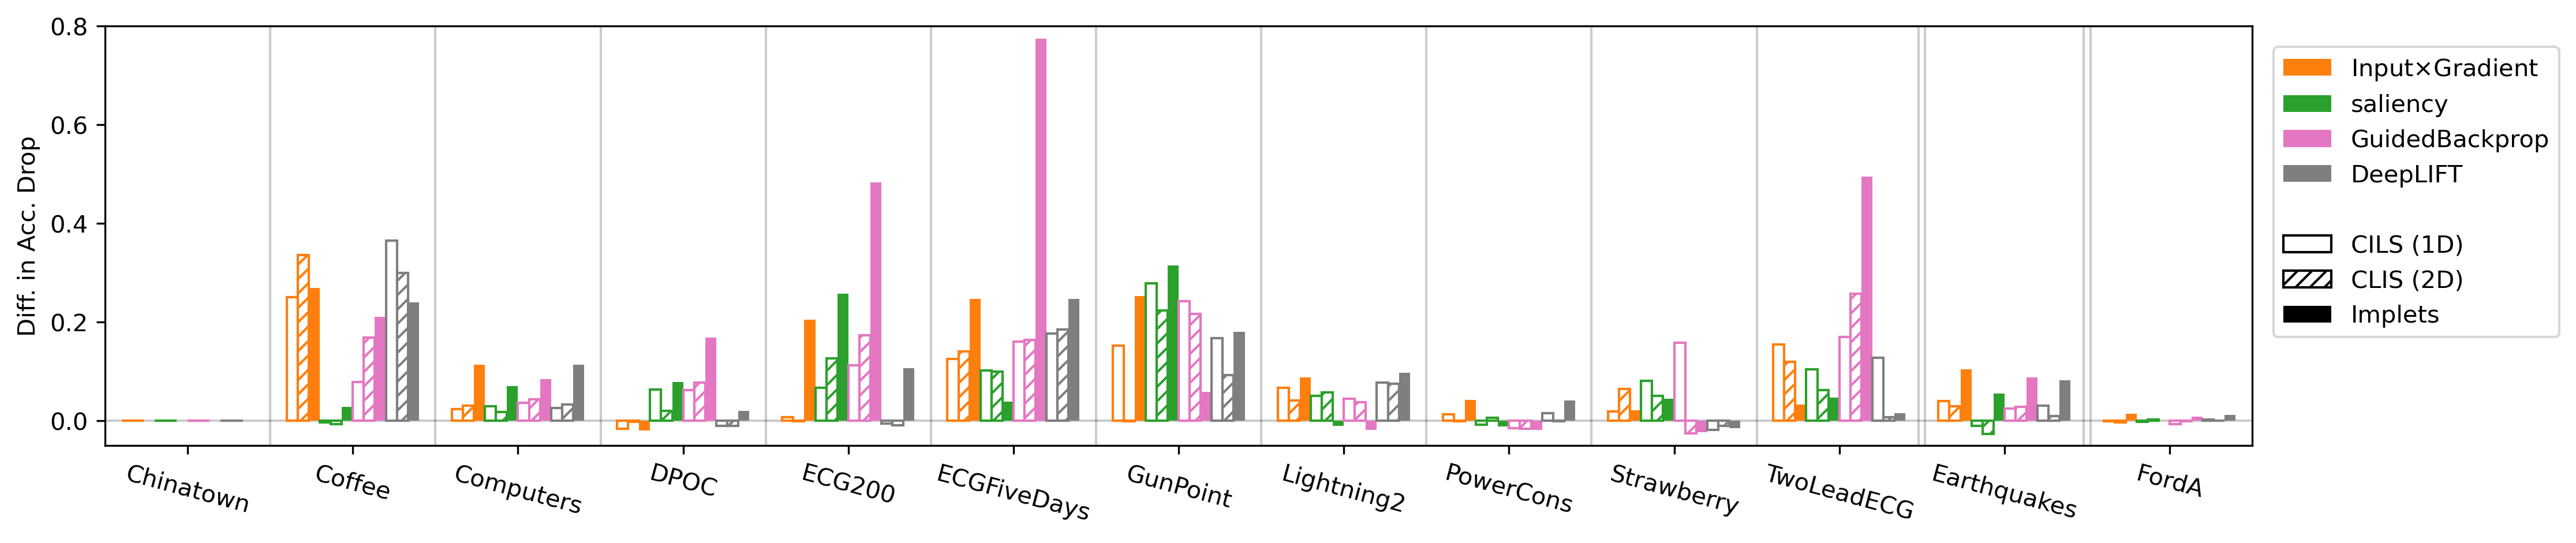

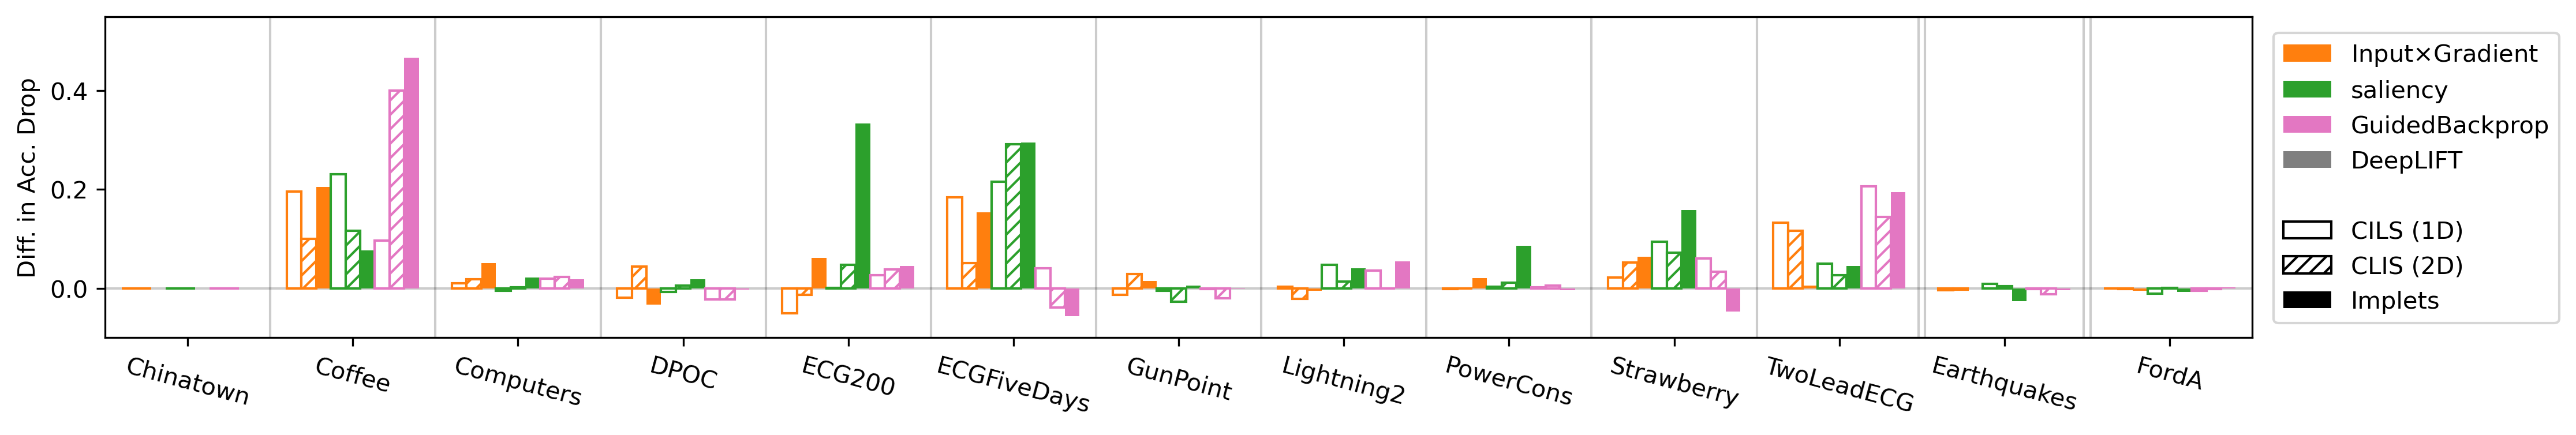

In [28]:
for model_name in ['FCN', 'InceptionTime']:
    ylim = (-0.05, 0.8) if model_name == 'FCN' else (-0.1, 0.55)    
    fig, ax = plt.subplots(dpi=300, figsize=(16, 4 * (ylim[1] - ylim[0]) / 1.08))
    hue_order = legend_map.values()
    if model_name == 'InceptionTime':
        hue_order = [v for v in hue_order if v != 'DeepLIFT']
    bars = sns.barplot(df_bar[df_bar['model_name'] == model_name], x='task_name', y='acc_diff', hue='xai_name_x', 
                       order=task_name_map.values(), palette='tab20', saturation=1,
                       hue_order=explainer_subset_2d if model_name == 'FCN' else explainer_subset_2d[:-3], 
                       errorbar=None, ax=ax)

    tab20 = sns.color_palette("tab20").as_hex()
    colors = [plt.get_cmap('tab10')(i) for i in [1, 2, 6, 7]]
    hatches = [None, '////', None]
    for bar in bars.patches:
        i = tab20.index(mcolors.to_hex(bar.get_facecolor()))
        color = colors[i // 3]
        bar.set_facecolor(color)
        bar.set_hatch(hatches[i % 3])
        if i % 3 != 2:
            bar.set_edgecolor(bar.get_facecolor())
            bar.set_facecolor('white')
    
    ax.set_ylim(*ylim)
    ytick_start = ylim[0] - ((ylim[0] + 1e-10) % 0.2) + 0.2
    ax.set_yticks(np.arange(ytick_start, ylim[1], 0.2))
    ax.axhline(0, lw=1, color='black', alpha=0.2, zorder=-1)
    for i in range(len(tasks) - 1):
        if i == 10 or i == 11:
            ax.axvline(i + 0.48, lw=1, color='black', alpha=0.2, zorder=-1)
            ax.axvline(i + 0.52, lw=1, color='black', alpha=0.2, zorder=-1)
        else:
            ax.axvline(i + 0.5, lw=1, color='black', alpha=0.2, zorder=-1)
    ax.set_xticks(np.arange(len(tasks)), task_name_map.values(), rotation=-15)

    # plot random guess line
    # for j, task in enumerate(task_name_map.values()):
    #     acc = baseline[(baseline['model_name'] == model_name) & (baseline['task_name'] == task)]['acc_score'].mean()
    #     ax.plot([j - 0.5, j + 0.5], [acc - 0.5, acc - 0.5], lw=1, color='black', alpha=0.2, zorder=-1, ls='--')
    # ax.set_xlim(-0.5, 12.5)

    legend_elements = [
        Patch(facecolor=colors[i], label=explainer[:-6])
        for i, explainer in enumerate(explainer_subset_2d[::3])
    ]
    legend_elements.extend([
        Patch(alpha=0, label=''),
        Patch(facecolor='white', edgecolor='black', label='CILS (1D)'),
        Patch(facecolor='white', edgecolor='black', hatch='////', label='CLIS (2D)'),
        Patch(facecolor='black', label='Implets')
    ])

    ax.legend(handles=legend_elements, 
               bbox_to_anchor=(1.01, 0.95), loc='upper left', borderaxespad=0.)

    ax.set_xlabel('')
    ax.set_ylabel('Diff. in Acc. Drop')
    plt.show()